In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
import glob
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
import copy
import pickle as pkl
sys.path.append('../code')
#sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
from lensing_qso_cross_utils import *
import scipy.stats as sts

rot = hp.Rotator(coord=['C','G'])

In [3]:
nside=256
lmax=3*nside-1
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)

#pl.semilogy(pixwin_hr)
#pl.semilogy(beam)
#pl.show()

def prepare_k_data(in_map,pr4_alms='',pixwin = None,overwrite=False):
    try:
        if overwrite:
            raise ValueError("Force recomputation of LR kappa maps")
        else:
            print("Read",in_map)
            klr=hp.read_map(in_map)
    except:
        klm = hp.read_alm(pr4_alms) # read DR4 instead of DR3      
        klm[0]=0.+0.j
        lmax = hp.Alm.getlmax(len(klm))
        if pixwin is None:
            print("Cut pixwin at lmax")
            fl=np.ones(lmax+1)
            fl[3*nside-1:]=0.
            khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)
            klr = hp.ud_grade(khr,nside_out=nside)            
            khr=0.                    
        else:
            pixwin_hr = extrapolpixwin(256,lmax)
            fl = pixwin_hr
            klr=hp.alm2map(hp.almxfl(klm,fl),nside=nside,lmax=lmax,pol=False)
        hp.write_map(in_map,klr,coord='G',overwrite=overwrite)
    return klr

In [4]:
# compute delta  and k
klrMV=prepare_k_data('../../kappaPR42018_MV_lr.fits','/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits',pixwin=None,overwrite=False)
klrPP=prepare_k_data('../../kappaPR42018_PP_lr.fits','/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_PP.fits',pixwin=None,overwrite=False)
klrTT=prepare_k_data('../../kappaPR42018_TT_lr.fits','/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_TT.fits',pixwin=None,overwrite=False)
klr=prepare_k_data('../../kappaPR4_MV_lr.fits','/Users/gfabbian/Work/PR4_variations/PR4_klm_dat_p.fits',pixwin=None,overwrite=False)
klr_pw=prepare_k_data('../../kappaPR4_MV_lr_pixwin.fits','/Users/gfabbian/Work/PR4_variations/PR4_klm_dat_p.fits',pixwin=1,overwrite=False)
klrPR3_nosz = prepare_k_data('../../kappaPR3_nosz_lr.fits','/Users/gfabbian/Work/Planck/DR3/COM_Lensing_Szdeproj_4096_R3.00/TT/dat_klm.fits',pixwin=None,overwrite=False)

Read ../../kappaPR42018_MV_lr.fits
Read ../../kappaPR42018_PP_lr.fits
Read ../../kappaPR42018_TT_lr.fits
Read ../../kappaPR4_MV_lr.fits
Read ../../kappaPR4_MV_lr_pixwin.fits
Read ../../kappaPR3_nosz_lr.fits


In [5]:
# compute galactic masks
galmask80_lr= hp.read_map('../../planck_galmask80.fits')
galmask90_lr= hp.read_map('../../planck_galmask90.fits')
galmask70_lr= hp.read_map('../../planck_galmask70.fits')
galmask60_lr  = hp.read_map('../../planck_galmask60.fits')
galmask50_lr= hp.read_map('../../planck_galmask50.fits')
galmask40_lr= hp.read_map('../../planck_galmask40.fits')
galmask20_lr= hp.read_map('../../planck_galmask20.fits')

# read lensing mask: NB consisent with galmask70 + point source masks
lensmask_lr = hp.read_map('../../planck_lensmask.fits')


# Magellanic Cloud mask
mclouds = [(280.4652,-32.8884),(302.8084,-44.3277)] #Large MC and Small MC coordinates
r_mclouds = [4,2] #deg
#r_mclouds = [5,2] #deg
mclouds_mask = np.ones(hp.nside2npix(nside))
for i,lmc in enumerate(mclouds):
    mcpix = hp.query_disc(nside,hp.ang2vec(lmc[0],lmc[1],lonlat=True),np.deg2rad(r_mclouds[i]))
    mclouds_mask[mcpix]=0.
    


In [6]:
#NOTE # binmask is consistent with galmask80_lr of Planck


# selection function and binary mask
mask_c = hp.ud_grade(hp.read_map('../../catalog_spz/map_probability_dust_stars_m10_NSIDE64_G20.0.fits'),nside_out=nside)
sel = rot.rotate_map_pixel(mask_c)
binmask = sel>0
binmask = (sel>0)*galmask80_lr

# selection function and binary mask
mask_c204 = hp.ud_grade(hp.read_map('../../catalog_spz/map_probability_dust_stars_m10_NSIDE64_G20.4.fits'),nside_out=nside)
sel204 = rot.rotate_map_pixel(mask_c204)
binmask204 = sel204>0
binmask204 = (sel204>0)*galmask80_lr

# selection function and binary mask new catalog
mask_c20 = hp.ud_grade(hp.read_map('../../catalog_20230406/selection_function_NSIDE64_G20.0.fits'),nside_out=nside)
sel20 = rot.rotate_map_pixel(mask_c20)
binmask20 = sel20>0
binmask20 = (sel20>0)*galmask80_lr


# selection function and binary mask new catalog
mask_c205 = hp.ud_grade(hp.read_map('../../catalog_20230406/selection_function_NSIDE64_G20.5.fits'),nside_out=nside)
sel205 = rot.rotate_map_pixel(mask_c205)
binmask205 = sel205>0
binmask205 = (sel205>0)*galmask80_lr



In [8]:
def prepare_gaia_catalog(gaia_fname,verbose=False,snr_cut=0.):# Prepare raw GAIA data
    if verbose:
        print("Read catalog and convert coordinate")
    d=fits.open(gaia_fname)

    z = d[1].data['redshift_spz']
    try:
        zerr = d[1].data['redshift_spz_err']
        snr = z/zerr
    except:
        # works for old routines
        zerr=np.zeros(len(z))
        snr = 3*np.ones(len(z))
    sc = SkyCoord(ra=d[1].data["ra"], dec=d[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
    gs = sc.transform_to(frame='galactic')
    l = gs.l.value[snr>snr_cut] 
    b = gs.b.value[snr>snr_cut] 
    nqso = len(l)
    return z[snr>snr_cut] ,zerr[snr>snr_cut] ,l,b,nqso

z,zerr,l,b,nqso = prepare_gaia_catalog('../../catalog_spz/gaia_spz_G20.0.fits',snr_cut=2.)
z204,zerr204,l204,b204,nqso204 = prepare_gaia_catalog('../../catalog_spz/gaia_spz_G20.4.fits',snr_cut=2.)
z204old,zerr204old,l204old,b204old,nqso204old = prepare_gaia_catalog('../../gaia_G20.4.fits',snr_cut=0.)

# includes all redshifts (cut SNR=5 would remove 10% of the data)
z_all,zerr_all,l_all,b_all,nqso_all = prepare_gaia_catalog('../../catalog_spz/gaia_spz_G20.0.fits')

In [9]:
z20,zerr20,l20,b20,nqso20 = prepare_gaia_catalog('../../catalog_20230406/catalog_G20.0.fits',snr_cut=2.)
z205,zerr205,l205,b205,nqso205 = prepare_gaia_catalog('../../catalog_20230406/catalog_G20.5.fits',snr_cut=2.)



In [19]:
def counts_selcorrected(l,b,selection,weight=None):
    selection_mask = selection>0
    m=make_counts(nside,l,b,weight=weight)
    msel=np.zeros(hp.nside2npix(nside))
    msel[selection_mask] = m[selection_mask]/selection[selection_mask]
    return msel

def process_catalog(l,b,selection,nbar_confidence_mask=None,weight=None):
    msel=counts_selcorrected(l,b,selection,weight)
    selection_mask = selection>0
    if nbar_confidence_mask is None:
        nbar = np.mean(msel[selection_mask]) 
    else:
        nbar = np.mean(msel[selection_mask&nbar_confidence_mask]) 
    print("nbar",nbar)
    csel = overdensity_from_counts(msel,nbar,verbose=False) 
    return csel

def process_catalog_splits(l,b,selection,nbar_confidence_mask=None,nreal=1,weight=None):
    selection_mask = selection>0
    if nbar_confidence_mask is not None:
        selection_mask=selection_mask&nbar_confidence_mask
    data=[]
    for i in range(nreal):
        split_reshuffle = np.arange(len(l))
        np.random.shuffle(split_reshuffle)    

        # splits
        m1sel = counts_selcorrected((l[split_reshuffle])[0::2],(b[split_reshuffle])[0::2],selection,weight=weight)
        m2sel = counts_selcorrected((l[split_reshuffle])[1::2],(b[split_reshuffle])[1::2],selection,weight=weight)
    
        c1sel = overdensity_from_counts(m1sel,selection_mask,verbose=False) 
        c2sel = overdensity_from_counts(m2sel,selection_mask,verbose=False) 
        jksel =(c2sel-c1sel)/2
        
        data.append([c1sel,c2sel,jksel])
    if nreal==1:
        return data[0]
    else:
        return data
    
def process_catalog_and_splits(l,b,selection,nbar_confidence_mask=None,weight=None):
    c =process_catalog(l,b,selection,nbar_confidence_mask=nbar_confidence_mask,weight=weight)
    c1,c2,cjk =process_catalog_splits(l,b,selection,nbar_confidence_mask=nbar_confidence_mask,nreal=1,weight=weight)    
    return c,c1,c2,cjk


def compute_dndz(z,zerr,npts=600,zmin=0,zmax=6,normalize=True):
    nqso = len(zerr)
    zgrid=np.linspace(zmin,zmax,npts)
    dndz_zerr=np.ones(npts)
    for i in range(nqso):
        dndz_zerr += np.exp(-(z[i]-zgrid)**2/(0.5*zerr[i]**2))/np.sqrt(2*np.pi)/zerr[i]    
    if normalize:
        dndz_zerr=dndz_zerr/np.trapz(dndz_zerr,dx=np.diff(zgrid)[0])
    return dndz_zerr,zgrid

In [47]:
#npts=600
#zgrid=np.linspace(0,6,npts)
#dndz_zerr=np.ones(npts)
#dndz_zerr204=np.ones(npts)
#for i in range(nqso):
#    dndz_zerr += np.exp(-(z[i]-zgrid)**2/(0.5*zerr[i]**2))/np.sqrt(2*np.pi)/zerr[i]
#    
#for i in range(nqso204):
#    dndz_zerr204 += np.exp(-(z204[i]-zgrid)**2/(0.5*zerr204[i]**2))/np.sqrt(2*np.pi)/zerr204[i]    
#    
#
#dndz_zerr=dndz_zerr/np.trapz(dndz_zerr,dx=np.diff(zgrid)[0])
#dndz_zerr204=dndz_zerr204/np.trapz(dndz_zerr204,dx=np.diff(zgrid)[0])

In [20]:
dndz_zerr,zgrid = compute_dndz(z,zerr)
dndz_zerr204,zgrid204 = compute_dndz(z204,zerr204)

dndz_zerr20,zgrid20 = compute_dndz(z20,zerr20)
dndz_zerr205,zgrid205 = compute_dndz(z205,zerr205)


Text(0.5, 0.98, 'dN/dz comparison')

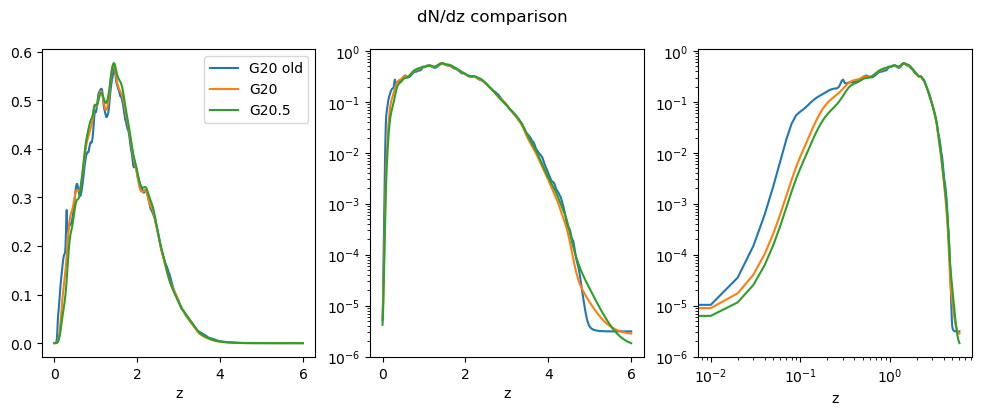

In [309]:
pl.figure(figsize=(12,4))
pl.subplot(131)
pl.plot(zgrid,dndz_zerr,label='G20 old')
pl.plot(zgrid,dndz_zerr20,label='G20')
pl.plot(zgrid,dndz_zerr205,label='G20.5')
pl.xlabel('z')
pl.legend()
pl.subplot(132)
pl.plot(zgrid,dndz_zerr,label='G20 old')
pl.plot(zgrid,dndz_zerr20,label='G20')
pl.plot(zgrid,dndz_zerr205,label='G20.5')
pl.yscale('log')
#pl.ylim(2e-06,1e-01)
#pl.xscale('log')
pl.xlabel('z')

pl.subplot(133)
pl.plot(zgrid,dndz_zerr,label='G20 old')
pl.plot(zgrid,dndz_zerr20,label='G20')
pl.plot(zgrid,dndz_zerr205,label='G20.5')
pl.yscale('log')
pl.xscale('log')
pl.xlabel('z')

pl.suptitle("dN/dz comparison")
#print(len(z),len(z20),len(z204),len(z205))

In [358]:

dndz_spz20= pl.hist(z20,bins=100,density=True,alpha=0.5,label='z SPZ')
dndz_spz20=[np.diff(dndz_spz20[1])+dndz_spz20[1][:-1],dndz_spz20[0]]
dndz_spz20[1]/=np.trapz(dndz_spz20[1],dndz_spz20[0])


dndz_spz205= pl.hist(z205,bins=100,density=True,alpha=0.1,label='z SPZ 20.5')
dndz_spz205=[np.diff(dndz_spz205[1])+dndz_spz205[1][:-1],dndz_spz205[0]]
dndz_spz205[1]/=np.trapz(dndz_spz205[1],dndz_spz205[0])

pl.close()
pl.show()
np.savetxt('dndz_tabulated_20230406.dat',np.array([dndz_spz20[0],dndz_spz20[1],dndz_spz205[1]]).T,header='#z dndz dndzG20.5')
np.savetxt('dndz_zerr_20230406.dat',np.array([zgrid20,dndz_zerr20,dndz_zerr205]).T,header='#zgrid dndz dndzG20.5')

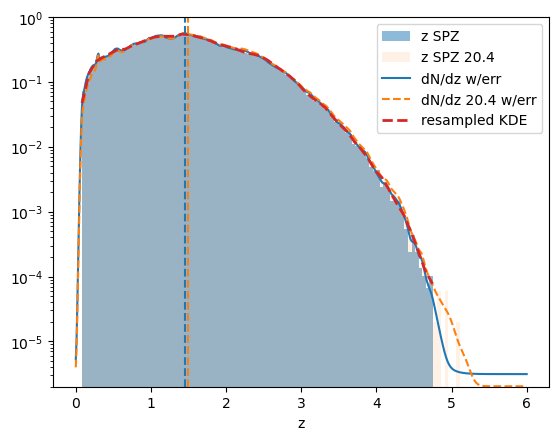

In [23]:

dndz_spz= pl.hist(z,bins=100,density=True,alpha=0.5,label='z SPZ')
dndz_spz=[np.diff(dndz_spz[1])+dndz_spz[1][:-1],dndz_spz[0]]
dndz_spz[1]/=np.trapz(dndz_spz[1],dndz_spz[0])


dndz_spz204= pl.hist(z204,bins=100,density=True,alpha=0.1,label='z SPZ 20.4')
dndz_spz204=[np.diff(dndz_spz204[1])+dndz_spz204[1][:-1],dndz_spz204[0]]
dndz_spz204[1]/=np.trapz(dndz_spz204[1],dndz_spz204[0])

np.savetxt('dndz_tabulated.dat',np.array([dndz_spz[0],dndz_spz[1],dndz_spz204[1]]).T,header='#z dndz dndzG20.4')
np.savetxt('dndz_zerr.dat',np.array([zgrid,dndz_zerr,dndz_zerr204]).T,header='#zgrid dndz dndzG20.4')
pl.plot(zgrid,dndz_zerr/np.trapz(dndz_zerr,dx=np.diff(zgrid)[0]),label='dN/dz w/err',color='C0')
pl.plot(zgrid,dndz_zerr204/np.trapz(dndz_zerr204,dx=np.diff(zgrid)[0]),label='dN/dz 20.4 w/err',color='C1',ls='--')

h,e = np.histogram(z, bins=100, density=True)
x = np.linspace(e.min(), e.max())

# plot the histogram
#pl.figure(figsize=(8,6))
#pl.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

# resample the histogram and find the KDE.
resamples = np.random.choice((e[:-1] + e[1:])/2, size=nqso, p=h/h.sum())
rkde = sts.gaussian_kde(resamples)

# plot the KDE
pl.plot(x, rkde.pdf(x)/np.trapz(rkde.pdf(x),dx=np.diff(x)[0]), '--', c='C3', lw=2, label='resampled KDE')

pl.axvline(np.median(z),color='C0',ls='--',lw=1.5)
pl.axvline(np.median(z204),color='C1',ls='--',lw=1.5)
pl.xlabel('z')
#pl.xscale("log")
pl.yscale("log")
pl.ylim(2e-6,1)
pl.legend()
pl.show()


In [72]:
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


def init_pars(do_magnification_bias=False):

    pars = camb.CAMBparams()
    lmax=1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.02242, omch2=0.11933, mnu=0,tau=0.0561)
    As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=0.9665)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = True
    
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = 100
    pars.SourceTerms.counts_lensing = do_magnification_bias  
    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = False #weird problems at times
    pars.SourceTerms.counts_radial   = False # negligible at l<10
    pars.SourceTerms.counts_timedelay = False # negligible
    pars.SourceTerms.counts_ISW = False #negligible
    pars.SourceTerms.counts_velocity = False #negligible
    pars.SourceTerms.counts_potential = False #negligible
    pars.SourceTerms.counts_evolve = False # not sure what this is
    
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 1.0
    return pars 

pars = init_pars()

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
b_quasar=2.1#35
#W=np.array(dndz_spz[1])
#z=np.array(dndz_spz[0])
W=np.array(dndz_zerr)
W204=np.array(dndz_zerr204)
z_W=np.array(zgrid)
pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z_W)), z=z_W, W=W,source_type='counts',dlog10Ndm = 0.0)]

results = camb.get_results(pars)
#cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 

pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(x)), z=x, W=rkde.pdf(x),source_type='counts',dlog10Ndm = 0.0)]
results_kde = camb.get_results(pars)
cls_kde = results_kde.get_source_cls_dict(raw_cl=True) 

pars.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z_W)), z=z_W, W=W204,source_type='counts',dlog10Ndm = 0.0)]
results_204 = camb.get_results(pars)
cls_204 = results_204.get_source_cls_dict(raw_cl=True) 


In [35]:
def process_mask(kappa,g,g1,g2,jk,apodized_mask,binning,w=None,return_error=False, templates=None, templates_kappa=None):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    
    fkappa = nmt.NmtField(apodized_mask, [kappa],beam=beam, templates=templates_kappa) # corrects for pixel window as klr computed from downgrade
    
    if w is None:
        w = nmt.NmtWorkspace()
        w.compute_coupling_matrix(fkappa, fkappa, binning)    

    fg = nmt.NmtField( apodized_mask, [g],beam=beam, templates=templates)
    fg1 = nmt.NmtField(apodized_mask, [g1],beam=beam, templates=templates)
    fg2 = nmt.NmtField(apodized_mask, [g2],beam=beam, templates=templates)
    fjk = nmt.NmtField(apodized_mask, [jk],beam=beam, templates=templates)
    
    clkg = compute_master(fkappa, fg, w)[0]
    clgg = compute_master(fg, fg, w)[0]
    clkk = compute_master(fkappa, fkappa, w)[0]
    
    clkg1 = compute_master(fkappa, fg1, w)[0]
    clg1g1 = compute_master(fg1, fg1, w)[0]
    
    clkg2 = compute_master(fkappa, fg2, w)[0]
    clg2g2 = compute_master(fg2, fg2, w)[0]
    
    clg1g2 = compute_master(fg1, fg2, w)[0]
    clkgjk = compute_master(fkappa, fjk, w)[0]
    clgjk = compute_master(fjk, fjk, w)[0]
    
    all_data = np.array([clkg,clgg,clkk,clkg1,clg1g1,clkg2,clg2g2,clg1g2,clkgjk,clgjk])
    if return_error:
        fsky= np.mean(apomask**2)**2/np.mean(apomask**4)
        delta_ell = binning.get_nell_list()
        prefac_auto = np.sqrt(2/(2*binning.get_effective_ells() +1)/delta_ell/fsky)
        prefac_cross= prefac_auto/np.sqrt(2)
        dclkg = prefac_cross * np.sqrt(clgg*clkk+clkg**2)
        dclgg = prefac_auto * np.abs(clgg)
        dclkk = prefac_auto * np.abs(clkk)
        dclkg1 = prefac_cross * np.sqrt(clg1g1*clkk+clkg1**2)
        dclg1g1 = prefac_auto * np.abs(clg1g1)
        dclkg2 = prefac_cross * np.sqrt(clg2g2*clkk+clkg2**2)
        dclg2g2 = prefac_auto * np.abs(clg2g2)
        dclg1g2 = prefac_cross * np.sqrt(clg2g2*clg1g1+clg1g2**2)
        dclkgjk = prefac_cross * np.sqrt(clgjk*clkk+clkgjk**2)
        dclgjk = prefac_auto * np.abs(clgjk)
        error_data = np.array([dclkg,dclgg,dclkk,dclkg1,dclg1g1,dclkg2,dclg2g2,dclg1g2,dclkgjk,dclgjk])
        return all_data,error_data
    else:
        return all_data
    
    

def process_mask_gXg(kappa,l,b,apodized_mask,binning,selection,nbar_confidence_mask=None,nreal=1,
                     w=None,return_error=False, templates=None, templates_kappa=None):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    
    fkappa = nmt.NmtField(apodized_mask, [kappa],beam=beam, templates=templates_kappa) # corrects for pixel window as klr computed from downgrade
    if w is None:
        w = nmt.NmtWorkspace()
        w.compute_coupling_matrix(fkappa, fkappa, binning) 
    clg1g1 =0.
    clg1g2 =0.
    clg2g2 =0.    
    clkgjk =0.
    clgjk  =0.
    
    clkk = compute_master(fkappa, fkappa, w)[0]
    
    for n in range(nreal):
        g1,g2,jk = process_catalog_splits(l,b,selection=selection,nbar_confidence_mask=nbar_confidence_mask,nreal=1)     
        fg1 = nmt.NmtField(apodized_mask, [g1],beam=beam, templates=templates)
        fg2 = nmt.NmtField(apodized_mask, [g2],beam=beam, templates=templates)
        fjk = nmt.NmtField(apodized_mask, [jk],beam=beam, templates=templates)
    
        clg1g1 += (compute_master(fg1, fg1, w)[0])/nreal
        clg2g2 += (compute_master(fg2, fg2, w)[0])/nreal
        clg1g2 += (compute_master(fg1, fg2, w)[0])/nreal
        
        clkgjk += (compute_master(fkappa, fjk, w)[0])/nreal
        clgjk  += (compute_master(fjk, fjk, w)[0])/nreal
    
    all_data = np.array([clg1g1,clg1g2,clg2g2,clkgjk,clgjk])
    if return_error:
        fsky= np.mean(apomask**2)**2/np.mean(apomask**4)
        delta_ell = binning.get_nell_list()
        prefac_auto = np.sqrt(2/(2*binning.get_effective_ells() +1)/delta_ell/fsky)
        prefac_cross= prefac_auto/np.sqrt(2)
        dclg1g1 = prefac_auto * np.abs(clg1g1)
        dclg2g2 = prefac_auto * np.abs(clg2g2)
        dclg1g2 = prefac_cross * np.sqrt(clg2g2*clg1g1+clg1g2**2)
        dclkgjk = prefac_cross * np.sqrt(clgjk*clkk+clkgjk**2)
        dclgjk = prefac_auto * np.abs(clgjk)
        error_data = np.array([dclg1g1,dclg1g2,dclg2g2,dclkgjk,dclgjk])
        return all_data,error_data
    else:
        return all_data
    
    

    
    
    

In [348]:
import os

try:
    print("Read FG TEMPLATES")
    with open("fg_templates_dict.pkl","rb") as f:
        templates_dict=pkl.load(f)
except:
    templates = sorted(list(glob.glob('/Users/gfabbian/Work/Planck/DR2/Foregrounds/commander/*')))
    templates_hr = sorted(list(glob.glob('/Users/gfabbian/Work/Planck/DR2/*.fits') 
                    )+list(glob.glob('/Users/gfabbian/Work/Planck/DR3/*Comp*2048*')))
    templates_ext = sorted(list(glob.glob('/Users/gfabbian/Work/data/*.fits')))
    print("Compute FG TEMPLATES")
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    fwhm=0
    tname = []
    s_list =[]
    bls_list = []
    s_mask_list=[]
    
    for t in templates+templates_hr+templates_ext:
        s_temp,h = hp.read_map(t,h=True,field=0,hdu=1)
        #if (('IRIS' in t) or ('wssa' in t) or ('SZ' in t)):
        if (('SZ' in t) or ('DustPol' in t) or ('freefree-commander_2048' in t) or ('SFD98' in t)):
            continue
        elif ('IRIS' in t):
            tname.append('IRIS')     
            fwhm=4
        elif ('wssa' in t):
            tname.append('WSSA')             
            fwhm = 5
        elif ('recon' in t):
            fwhm = float(((os.path.basename(t).split('_')[1])[2:]).replace('-','.'))
            tname.append('Mudur+%.1f'%fwhm)             
            s_temp= hp.read_map(t,field=1,hdu=1)
        elif 'sfd' in t:
            fwhm = 6.
            tname.append('SFD')  
        elif 'Zodi' in t:
            fwhm = 4.8
            
            tname.append(os.path.basename(t).split('_')[2])
        else:
            try:
                tags = np.array([i[0] for i in h])
                fwhm = float(h[int(np.where(tags=='FWHM')[0])][1])
            except:
                fwhm = 5.
            tname.append(t.split('CompMap_')[1].split('_')[0])
        print("Processing",os.path.basename(t),fwhm)
        bl_t = hp.gauss_beam(fwhm/60.,lmax=3*nside-1)
        nside_t = hp.npix2nside(len(s_temp))
        if nside_t != nside:
            s_temp_badpix = (s_temp==hp.UNSEEN) | (s_temp==0)
            if np.sum(s_temp_badpix):
                print("Correct badpix",tname[-1])
                s_temp[s_temp_badpix] = 0.
                s_temp_mask = hp.ud_grade(s_temp>0,nside_out=nside)
                s_temp_mask[s_temp_mask<0.5]=0.
                pixwin_temp = hp.pixwin(nside_t,lmax=2*nside_t-1)
            else:
                s_temp_mask = 1.
                pixwin_temp = 1.
            t_alm = hp.map2alm(s_temp,lmax=2*nside_t-1,pol=False)
            beam_hr = extrapolpixwin(nside,2*nside_t-1)
            t_alm = hp.almxfl(t_alm,beam_hr/pixwin_temp)
            s_temp=hp.alm2map(t_alm,nside,pol=False)
            s_temp = s_temp*s_temp_mask
    
            
        else:
            s_temp_mask =1.
        s_mask_list.append(s_temp_mask)
        s_list.append(s_temp)
        bls_list.append(bl_t)
    templates_dict={}
    for i,k in enumerate(tname):
        templates_dict[k]={}
        templates_dict[k]['data']=s_list[i]
        templates_dict[k]['mask']=s_mask_list[i]    
        templates_dict[k]['bls']=bls_list[i]    
    with open("fg_templates_dict.pkl","wb") as f:
        pkl.dump(templates_dict,f)

Read FG TEMPLATES


In [351]:
def get_covariance_from_model(kappa,g,cls,apodized_mask,binning,w=None):
    # corrects for pixel window function
    beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)
    l=np.arange(len(cls['PxP']))
    p2k=l*(l+1)/2
    
    f0 = nmt.NmtField(apodized_mask, [kappa],beam=beam)
    f1 = nmt.NmtField(apodized_mask, [g],beam=beam)    
    if w is None:
        w = nmt.NmtWorkspace()
        w.compute_coupling_matrix(f0, f0, binning)    
    cl_00 = compute_master(f0, f1, w)[0]
    n_ell = len(cl_00)
    
    print("Covariance")
    cw0101 = nmt.NmtCovarianceWorkspace()
    cw0101.compute_coupling_coefficients(f0, f1, f0, f1)

    cw1111 = nmt.NmtCovarianceWorkspace()
    cw1111.compute_coupling_coefficients(f1, f1, f1, f1)    
    
    cw0111 = nmt.NmtCovarianceWorkspace()
    cw0111.compute_coupling_coefficients(f0, f1, f1, f1)  
    
    cw0000 = nmt.NmtCovarianceWorkspace()
    cw0000.compute_coupling_coefficients(f0, f0, f0, f0)      
    
    covar_kg_gg = nmt.gaussian_covariance(cw0111,0, 0, 0, 0,[cls['PxW1']*p2k],[cls['PxW1']*p2k],[cls['W1xW1']],[cls['W1xW1']],
                                      w, wb=w).reshape([n_ell, 1,n_ell, 1])[:, 0, :, 0]
    corr_kg_gg = covar_kg_gg/np.sqrt(np.outer(covar_kg_gg.diagonal(),covar_kg_gg.diagonal()))
    
    covar_gg_gg = nmt.gaussian_covariance(cw1111,0, 0, 0, 0,[cls['W1xW1']],[cls['W1xW1']],[cls['W1xW1']],[cls['W1xW1']],
                                      w, wb=w).reshape([n_ell, 1,n_ell, 1])[:, 0, :, 0]
    corr_gg_gg = covar_gg_gg/np.sqrt(np.outer(covar_gg_gg.diagonal(),covar_gg_gg.diagonal()))        
    
    covar_kg_kg = nmt.gaussian_covariance(cw0101,0, 0, 0, 0,[cls['PxP']*p2k**2],[cls['PxW1']*p2k],[cls['PxW1']*p2k],[cls['W1xW1']],
                                      w, wb=w).reshape([n_ell, 1,n_ell, 1])[:, 0, :, 0] 
    corr_kg_kg = covar_kg_kg/np.sqrt(np.outer(covar_kg_kg.diagonal(),covar_kg_kg.diagonal()))        
    
    covar_kk_kk = nmt.gaussian_covariance(cw0000,0, 0, 0, 0,[cls['PxP']*p2k**2],[cls['PxP']*p2k**2],[cls['PxP']*p2k**2],[cls['PxP']*p2k**2],
                                      w, wb=w).reshape([n_ell, 1,n_ell, 1])[:, 0, :, 0] 
    corr_kk_kk = covar_kk_kk/np.sqrt(np.outer(covar_kk_kk.diagonal(),covar_kk_kk.diagonal()))
    #return covar_kg_kg,covar_gg_gg,covar_kg_gg,covar_kk_kk
    #print(covar_kg_kg/covar_gg_gg)
    #return covar_kg_kg,covar_gg_gg,covar_kg_gg    

    totcorr=np.zeros((2*n_ell,2*n_ell))
    totcorr[0:n_ell,0:n_ell] = corr_kg_kg
    totcorr[0:n_ell,n_ell:2*n_ell] = corr_kg_gg
    totcorr[n_ell:2*n_ell,0:n_ell] = corr_kg_gg.T    
    totcorr[n_ell:2*n_ell,n_ell:2*n_ell] = corr_gg_gg     
    
    
    totcorr2=np.zeros((2*n_ell,2*n_ell))
    totcorr2[0:n_ell,0:n_ell] = covar_kg_kg
    totcorr2[0:n_ell,n_ell:2*n_ell] = covar_kg_gg
    totcorr2[n_ell:2*n_ell,0:n_ell] = covar_kg_gg.T    
    totcorr2[n_ell:2*n_ell,n_ell:2*n_ell] = covar_gg_gg     
    totcorr2 = totcorr2/np.sqrt(np.outer(totcorr2.diagonal(),totcorr2.diagonal()))        
    return totcorr,covar_kg_kg,covar_kg_gg,covar_gg_gg,covar_kk_kk,totcorr2
    




In [352]:
data_model = dict(cls)
nlkk = np.loadtxt('/Users/gfabbian/Work/PR4_variations/PR4_nlkk_p.dat',unpack=True)
nlkk[0]=0.
ell=np.arange(len(cls['PxP']))
p2k=ell*(ell+1)/2
nlkk = nlkk[0:len(ell)]

data_model['PxP']+= nlkk/p2k**2
data_model['PxP'][0]=0.
noise_gg = np.interp(ell,lb,clgjk)
noise_gg[0]=0.
data_model['W1xW1'] += noise_gg

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/3747157116.py:8: RuntimeWarning: invalid value encountered in divide
  data_model['PxP']+= nlkk/p2k**2


In [636]:
data_test={}
for fsky, mygalmask in zip([70,60,50,40,20],[galmask70_lr,galmask60_lr,galmask50_lr,galmask40_lr,galmask20_lr]):
    c,c1,c2,cjk   = process_catalog_and_splits(l,b,sel,mygalmask.astype(bool)&mclouds_mask.astype(bool))
    #nosel= np.ones(hp.nside2npix(nside))*galmask70_lr
    #c_nosel,c1_nosel,c2_nosel,cjk_nosel   = process_catalog_and_splits(l,b,nosel,galmask50_lr.astype(bool)&mclouds_mask.astype(bool))
    #c_all,c1_all,c2_all,cjk_all = process_catalog_and_splits(l_all,b_all,sel,galmask50_lr.astype(bool)&mclouds_mask.astype(bool))
    c_204,c1_204,c2_204,cjk_204 = process_catalog_and_splits(l204,b204,sel204,mygalmask.astype(bool)&mclouds_mask.astype(bool))
    #c_204old,c1_204old,c2_204old,cjk_204old = process_catalog_and_splits(l204old,b204old,sel204)
    
    binning = get_custom_binning(20)
    #apomask = nmt.mask_apodization(galmask70_lr*mclouds_mask,1., apotype="C2")
    apomask = nmt.mask_apodization(mygalmask*lensmask_lr,1., apotype="C2")
    apomask = apomask*sel
    apomask204 = apomask*sel204
    
    cls_mv= process_mask(klrMV,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_tt= process_mask(klrTT,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pp= process_mask(klrPP,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pr4= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pr3nosz= process_mask(klrPR3_nosz,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    #cls_pr4_pw= process_mask(klr_pw,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    #cls_pr4_all= process_mask(klr,c_all,c1_all,c2_all,cjk_all,apomask,binning,w=None,return_error=True)
    cls_pr4_204= process_mask(klr,c_204,c1_204,c2_204,cjk_204,apomask204,binning,w=None,return_error=True)
    
    
    # gal fg
    cls_pr4fg= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
                templates=None,templates_kappa=[[templates_dict['CIB-GNILC-F353']['data']]])
    cls_pr4fg2= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,templates=[[templates_dict['IRIS']['data']]])
    
    cls_pr4fg_204= process_mask(klr,c_204,c1_204,c2_204,cjk_204,apomask204,binning,w=None,return_error=True,templates=[[templates_dict['CIB-GNILC-F545']['data']]])
    cls_pr4fg2_204= process_mask(klr,c_204,c1_204,c2_204,cjk_204,apomask204,binning,w=None,return_error=True,templates=[[templates_dict['IRIS']['data']]])
    
    # instrumental syst 
    #cls_pr4fg3= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[templates_dict['545-Zodi']['data']]])
    #cls_pr4fg3= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[hp.ud_grade(m10,nside_out=nside)]],templates_kappa = [[hp.ud_grade(m10,nside_out=nside)]])
    
    #cls_pr4fg4= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[hp.ud_grade(stars,nside_out=nside)]],templates_kappa = [[hp.ud_grade(stars,nside_out=nside)]])
    
    #cls_pr4fg3= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[sel]])
    #cls_pr4fg3_mean= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[zerrmap_mean]])
    
    [clg1g1,clg1g2,clg2g2,clkgjk,clgjk],[dclg1g1,dclg1g2,dclg2g2,dclkgjk,dclgjk]=process_mask_gXg(klr,l,b,apomask,binning,sel,(mygalmask.astype(bool)&mclouds_mask.astype(bool)),nreal=50,return_error=True)
    [clg1g1_204,clg1g2_204,clg2g2_204,clkgjk_204,clgjk_204],[dclg1g1_204,dclg1g2_204,dclg2g2_204,dclkgjk_204,dclgjk_204]=process_mask_gXg(klr,l204,b204,apomask204,binning,sel204,(mygalmask.astype(bool)&mclouds_mask.astype(bool)),nreal=50,return_error=True)
    
        
    data_test[fsky]={'G20':{},'G20.4':{}}
    data_test[fsky]['G20']['clkg'] = [cls_pr4[0][0],cls_pr4[1][0]]
    data_test[fsky]['G20']['clgXg'] = [clg1g2,dclg1g2]
    data_test[fsky]['G20']['clgg'] = [cls_pr4[0][1]-clgjk,cls_pr4[1][1]]
    data_test[fsky]['G20']['clgjk'] =  [clgjk,dclgjk]
    data_test[fsky]['G20']['clkgjk'] =  [clkgjk,dclkgjk]
    data_test[fsky]['G20']['clkk'] =  [cls_pr4[0][2],cls_pr4[1][2]]
    data_test[fsky]['G20']['cls_ktt'] =  [cls_tt]
    data_test[fsky]['G20']['cls_kpol'] =  [cls_pp]
    data_test[fsky]['G20']['cls_kmv'] =  [cls_mv]
    data_test[fsky]['G20']['cls_nodust'] =  [cls_pr4fg2]
    data_test[fsky]['G20']['cls_nocib'] =  [cls_pr4fg]
    data_test[fsky]['G20']['cls_pr3nosz'] =  [cls_pr3nosz]
    
    
    
    data_test[fsky]['G20.4']['clkg'] = [cls_pr4_204[0][0],cls_pr4_204[1][0]]
    data_test[fsky]['G20.4']['clgXg'] = [clg1g2_204,dclg1g2_204]
    data_test[fsky]['G20.4']['clgg'] = [cls_pr4_204[0][1]-clgjk_204,cls_pr4_204[1][1]]
    data_test[fsky]['G20.4']['clgjk'] =  [clgjk_204,dclgjk_204]
    data_test[fsky]['G20.4']['clkgjk'] =  [clkgjk_204,dclkgjk_204]
    data_test[fsky]['G20.4']['clkk'] =  [cls_pr4_204[0][2],cls_pr4_204[1][2]]
    
    
    
    
    
    [tot,kgkg,kggg,gggg,kkkk,tot2] = get_covariance_from_model(klr,c,data_model,apomask,binning)
    
    
    
    
    corr_test={}
    corr_test['tot'] = tot2
    #corr_test['tot2'] = tot # wrong normalization of off-diagonal blocks
    corr_test['kgkg'] = kgkg
    corr_test['kggg'] = kggg
    corr_test['kkkk'] = kkkk
    corr_test['gggg'] = gggg
    
    data_test[fsky]['corrmat'] = corr_test
    
    #with open("corr_mask.pkl","wb") as f:
    #    pkl.dump(corr_test,f)
        
    
    with open("dataset_kyoto.pkl","wb") as f:
        pkl.dump(data_test,f)

nbar 1.278297752907985
nbar 2.007556751728861
Covariance
nbar 1.2840081349131187
nbar 2.014373284914304
Covariance
nbar 1.2919161355370956
nbar 2.02497395174347
Covariance
nbar 1.2975162049226372
nbar 2.0293691893399894
Covariance
nbar 1.3096069771262235
nbar 2.0382775874895454
Covariance


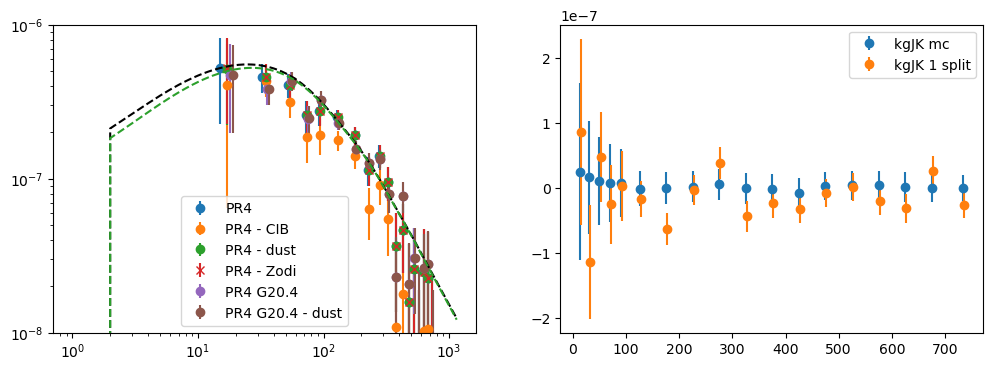

In [106]:
pl.figure(figsize=(12,4))
lb = binning.get_effective_ells() 
ell=np.arange(len(cls['PxP']))
p2k=ell*(ell+1)/2
pl.subplot(121)
#pl.errorbar(lb,cls_mv[0][0],cls_mv[1][0],marker='o',ls='')
#pl.errorbar(lb+1,cls_tt[0][0],cls_tt[1][0],marker='o',ls='')
pl.errorbar(lb+2,cls_pr4[0][0],cls_pr4[1][0],marker='o',ls='',label='PR4')
#pl.errorbar(lb+2,cls_pr4_pw[0][0],cls_pr4_pw[1][0],marker='o',ls='',label='PR4 pw smoothing')
#pl.errorbar(lb+3,cls_pp[0][0],cls_pp[1][0],marker='o',ls='')
#pl.errorbar(lb+4,cls_pr4_all[0][0],cls_pr4_all[1][0],marker='o',ls='')
pl.errorbar(lb+4,cls_pr4fg[0][0],cls_pr4fg[1][0],marker='o',ls='',label='PR4 - CIB')
pl.errorbar(lb+4,cls_pr4fg2[0][0],cls_pr4fg2[1][0],marker='o',ls='',label='PR4 - dust')
pl.errorbar(lb+4,cls_pr4fg3[0][0],cls_pr4fg3[1][0],marker='x',ls='',label='PR4 - Zodi')
pl.errorbar(lb+5,cls_pr4_204[0][0],cls_pr4_204[1][0],marker='o',ls='',label='PR4 G20.4')
#pl.errorbar(lb+4,cls_pr4fg_204[0][0],cls_pr4fg_204[1][0],marker='o',ls='',label='PR4 G20.4 -CIB')
pl.errorbar(lb+6,cls_pr4fg2_204[0][0],cls_pr4fg2_204[1][0],marker='o',ls='',label='PR4 G20.4 - dust')
pl.xscale("log")
pl.yscale("log")
pl.ylim(1e-08,1e-06)
pl.legend()
pl.errorbar(ell,cls['PxW1']*p2k,color='black',ls='--')
pl.errorbar(ell,cls_204['PxW1']*p2k,color='C2',ls='--')


pl.subplot(122)
pl.errorbar(lb,clkgjk,dclkgjk,marker='o',ls='',label='kgJK mc')
pl.errorbar(lb+2,cls_pr4[0][8],cls_pr4[1][8],marker='o',ls='',label='kgJK 1 split')
pl.legend()

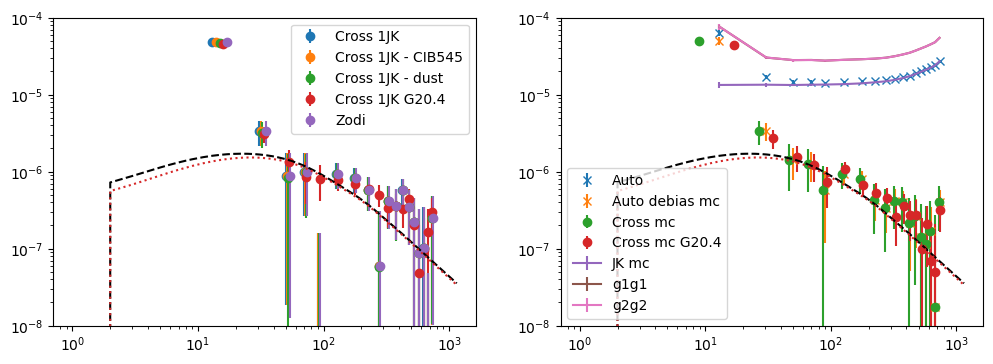

In [60]:
lb = binning.get_effective_ells() 
pl.figure(figsize=(12,4))
pl.subplot(121)
pl.errorbar(lb,cls_pr4[0][7],cls_pr4[1][7],marker='o',ls='',label='Cross 1JK')
#pl.errorbar(lb,cls_pr4_all[0][7],cls_pr4_all[1][7],marker='o',ls='')
pl.errorbar(lb+1,cls_pr4fg[0][7],cls_pr4fg[1][7],marker='o',ls='',label='Cross 1JK - CIB545')
pl.errorbar(lb+2,cls_pr4fg2[0][7],cls_pr4fg2[1][7],marker='o',ls='',label='Cross 1JK - dust')
pl.errorbar(lb+3,cls_pr4_204[0][7],cls_pr4_204[1][7],marker='o',ls='',label='Cross 1JK G20.4')
pl.errorbar(lb+4,cls_pr4fg3[0][7],cls_pr4fg3[1][7],marker='o',ls='',label='Zodi')
#pl.errorbar(lb+5,cls_pr4fg3_mean[0][1],cls_pr4fg3_mean[1][1],marker='o',ls='')
pl.errorbar(ell,cls['W1xW1'],color='black',ls='--')
#pl.errorbar(ell,cls_kde['W1xW1'],color='black',ls=':')
pl.errorbar(ell,cls_204['W1xW1'],color='C3',ls=':')
pl.xscale("log")
pl.yscale("log")
pl.ylim(1e-08,1e-4)
pl.legend()
#pl.ylim(1e-08,2e-6)
#pl.show()


pl.subplot(122)
#pl.errorbar(lb,cls_pr4[0][7],cls_pr4[1][7],marker='x',ls='',label='Cross 1 split')
pl.errorbar(lb,cls_pr4[0][1],cls_pr4[1][1],marker='x',ls='',label='Auto')
pl.errorbar(lb,cls_pr4[0][1]-clgjk,cls_pr4[1][1],marker='x',ls='',label='Auto debias mc')
pl.errorbar(lb-4,clg1g2,dclg1g2,marker='o',ls='',label='Cross mc')
pl.errorbar(lb+4,clg1g2_204,dclg1g2_204,marker='o',ls='',label='Cross mc G20.4')
pl.errorbar(lb,clgjk,dclgjk,marker='',ls='-',label='JK mc')
pl.errorbar(lb,clg1g1,dclg1g1,marker='',ls='-',label='g1g1')
pl.errorbar(lb,clg2g2,dclg2g2,marker='',ls='-',label='g2g2')
pl.errorbar(ell,cls['W1xW1'],color='black',ls='--')
#pl.errorbar(ell,cls_kde['W1xW1'],color='black',ls=':')
pl.errorbar(ell,cls_204['W1xW1'],color='C3',ls=':')
pl.xscale("log")
pl.yscale("log")
pl.legend()
pl.ylim(1e-08,1e-4)
pl.show()

# eBOSS

In [285]:
zmin = 0.9*0
zmax = 2.2*1000

eboss_n=fits.open("../../sdss/eBOSS_QSO_clustering_data-NGC-vDR16.fits")
eboss_s=fits.open("../../sdss/eBOSS_QSO_clustering_data-SGC-vDR16.fits")

z_eboss=np.append(eboss_n[1].data['Z'],eboss_s[1].data['Z'])
zmask_eboss=((z_eboss>zmin) & (z_eboss<zmax))

ra_eboss = np.append(eboss_n[1].data['RA'],eboss_s[1].data['RA'])[zmask_eboss]
dec_eboss= np.append(eboss_n[1].data['DEC'],eboss_s[1].data['DEC'])[zmask_eboss]

nqso_eboss = len(ra_eboss)

sc_eboss = SkyCoord(ra=ra_eboss, dec=dec_eboss, unit='deg', frame='icrs', equinox='J2000.0')
gs_eboss = sc_eboss.transform_to(frame='galactic')
l_eboss = gs_eboss.l.value
b_eboss = gs_eboss.b.value
l_eboss[l_eboss<0] = 360+l_eboss[l_eboss<0]

# combines systematics, completeness and redshift weight
weight_n = eboss_n[1].data['WEIGHT_SYSTOT']*eboss_n[1].data['WEIGHT_NOZ']*eboss_n[1].data['WEIGHT_CP']
weight_s = eboss_s[1].data['WEIGHT_SYSTOT']*eboss_s[1].data['WEIGHT_NOZ']*eboss_s[1].data['WEIGHT_CP']
systot_eboss = np.append(weight_n,weight_s)[zmask_eboss]


nbar 0.4370473225911458
366820.7962517366 343708.0


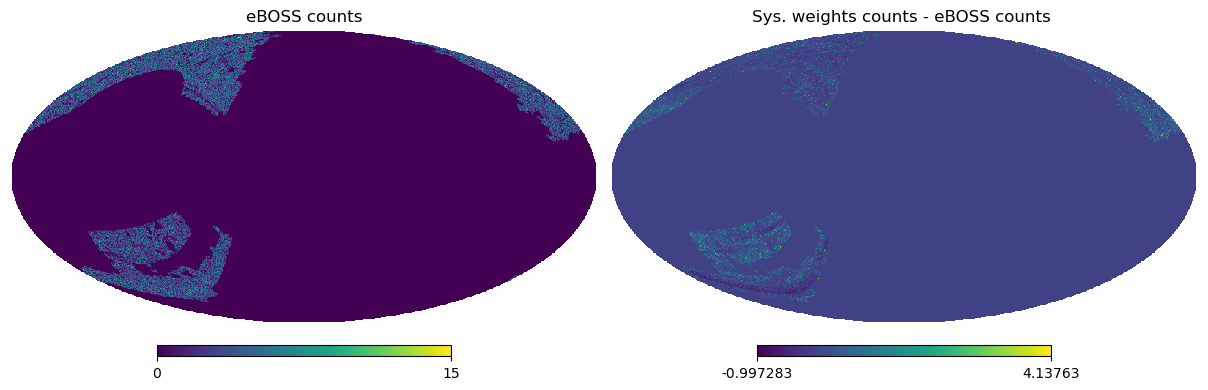

In [298]:
selection_eboss = np.ones(hp.nside2npix(nside))
counts_eboss = process_catalog(l_eboss,b_eboss,selection_eboss)

mask_eboss = ((hp.ud_grade(hp.ud_grade(counts_eboss,nside_out=64),nside_out=nside)) >0)

map_systot = make_counts(nside,l_eboss,b_eboss,weight=systot_eboss)
map_eboss = make_counts(nside,l_eboss,b_eboss)

pl.figure(figsize=(12,4))
hp.mollview(map_eboss*galmask70_lr,sub=121,title='eBOSS counts')
hp.mollview((map_systot-map_eboss)*galmask70_lr,sub=122,title='Sys. weights counts - eBOSS counts ')
#hp.mollview(map_eboss*galmask70_lr,sub=133,title='eBOSS counts')
pl.show()


In [642]:
data_test={}
for fsky, mygalmask in zip([70,60,50,40,20],[galmask70_lr,galmask60_lr,galmask50_lr,galmask40_lr,galmask20_lr]):
    c,c1,c2,cjk   = process_catalog_and_splits(l_eboss,b_eboss,selection_eboss,mygalmask.astype(bool)&mclouds_mask.astype(bool)&mask_eboss.astype(bool))
    
    binning = get_custom_binning(20)
    #apomask = nmt.mask_apodization(galmask70_lr*mclouds_mask,1., apotype="C2")
    apomask = nmt.mask_apodization(mygalmask*lensmask_lr*mask_eboss,1., apotype="C2")
    apomask = apomask
    
    cls_mv= process_mask(klrMV,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_tt= process_mask(klrTT,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pp= process_mask(klrPP,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pr4= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pr3nosz= process_mask(klrPR3_nosz,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    
    # gal fg
    cls_pr4fg= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
                templates=None,templates_kappa=[[templates_dict['CIB-GNILC-F353']['data']]])
    cls_pr4fg2= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,templates=[[templates_dict['IRIS']['data']]])
    
    
    [clg1g1,clg1g2,clg2g2,clkgjk,clgjk],[dclg1g1,dclg1g2,dclg2g2,dclkgjk,dclgjk]=process_mask_gXg(klr,l_eboss,b_eboss,apomask,binning,selection_eboss,(mygalmask.astype(bool)&mclouds_mask.astype(bool)&mask_eboss.astype(bool)),nreal=50,return_error=True)

    
        
    data_test[fsky]={'eboss':{}}
    data_test[fsky]['eboss']['clkg'] = [cls_pr4[0][0],cls_pr4[1][0]]
    data_test[fsky]['eboss']['clgXg'] = [clg1g2,dclg1g2]
    data_test[fsky]['eboss']['clgg'] = [cls_pr4[0][1]-clgjk,cls_pr4[1][1]]
    data_test[fsky]['eboss']['clgjk'] =  [clgjk,dclgjk]
    data_test[fsky]['eboss']['clkgjk'] =  [clkgjk,dclkgjk]
    data_test[fsky]['eboss']['clkk'] =  [cls_pr4[0][2],cls_pr4[1][2]]
    data_test[fsky]['eboss']['cls_ktt'] =  [cls_tt]
    data_test[fsky]['eboss']['cls_kpol'] =  [cls_pp]
    data_test[fsky]['eboss']['cls_kmv'] =  [cls_mv]
    data_test[fsky]['eboss']['cls_nodust'] =  [cls_pr4fg2]
    data_test[fsky]['eboss']['cls_nocib'] =  [cls_pr4fg]
    data_test[fsky]['eboss']['cls_pr3nosz'] =  [cls_pr3nosz]
        
    
    [tot,kgkg,kggg,gggg,kkkk,tot2] = get_covariance_from_model(klr,c,data_model,apomask,binning)
    
    
    
    
    corr_test={}
    corr_test['tot'] = tot2
    #corr_test['tot2'] = tot # wrong normalization of off-diagonal blocks
    corr_test['kgkg'] = kgkg
    corr_test['kggg'] = kggg
    corr_test['kkkk'] = kkkk
    corr_test['gggg'] = gggg
    
    data_test[fsky]['corrmat'] = corr_test
    
    #with open("corr_mask.pkl","wb") as f:
    #    pkl.dump(corr_test,f)
        
    
    with open("dataset_kyoto_eboss.pkl","wb") as f:
        pkl.dump(data_test,f)
        

nbar 3.3007331434729066
Covariance
nbar 3.3050248246817224
Covariance
nbar 3.3477069931521064
Covariance
nbar 3.5059472648127095
Covariance
nbar 3.604820894875904
Covariance


In [703]:
pars_eboss = init_pars()

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
b_quasar=2.35

dndz_eboss= np.histogram(z_eboss,bins=100,density=True)
dndz_eboss=[np.diff(dndz_eboss[1])+dndz_eboss[1][:-1],dndz_eboss[0]]
dndz_eboss[1]/=np.trapz(dndz_eboss[1],dndz_eboss[0])



#W_eboss=np.interp(zgrid,dndz_eboss[0],dndz_eboss[1],left=0,right=0)
W_eboss=np.array(dndz_eboss[1])
z_W_eboss=np.array(dndz_eboss[0])
pars_eboss.SourceWindows = [SplinedSourceWindow(bias_z=b_quasar*np.ones(len(z_W_eboss)), z=z_W_eboss, W=W_eboss,source_type='counts',dlog10Ndm = 0.4)]

results_eboss = camb.get_results(pars_eboss)
#cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls_eboss = results_eboss.get_source_cls_dict(raw_cl=True) 



# Gaia comparison with eBOSS

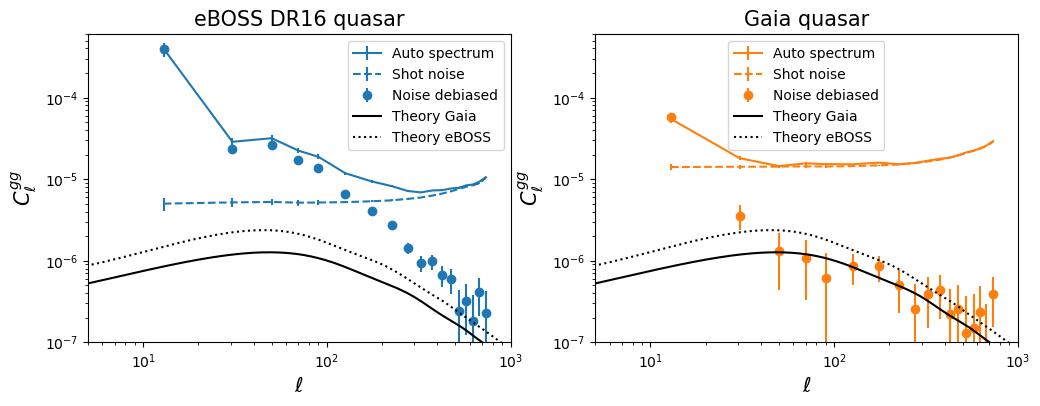

In [794]:
with open("dataset_kyoto.pkl","rb") as f:
    gaia_data = pkl.load(f)
    
with open("dataset_kyoto_eboss.pkl","rb") as f:
    eboss_data = pkl.load(f)    

pl.figure(figsize=(12,4))
pl.subplot(121)
pl.errorbar(lb,eboss_data[70]['eboss']['clgg'][0]+eboss_data[70]['eboss']['clgjk'][0],
            eboss_data[70]['eboss']['clgg'][1],ls='-',label='Auto spectrum')
pl.errorbar(lb,eboss_data[70]['eboss']['clgjk'][0],eboss_data[70]['eboss']['clgjk'][1],ls='--',color='C0',label='Shot noise')
pl.errorbar(lb,eboss_data[70]['eboss']['clgXg'][0],eboss_data[70]['eboss']['clgXg'][1],color='C0',marker='o',ls='',label='Noise debiased')
pl.errorbar(ell,cls['W1xW1'],color='black',ls='-',label='Theory Gaia')
pl.errorbar(ell,cls_eboss['W1xW1'],color='black',ls=':',label='Theory eBOSS')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell^{gg}$',size=15)
pl.xscale('log')
pl.yscale('log')
pl.title("eBOSS DR16 quasar",size=15)
pl.ylim(1e-7,6e-4)
pl.xlim(5,1000)
pl.legend()
pl.subplot(122)
pl.errorbar(lb,gaia_data[20]['G20']['clgg'][0]+gaia_data[70]['G20']['clgjk'][0],
            gaia_data[70]['G20']['clgg'][1],marker='',ls='-',color='C1',label='Auto spectrum')
pl.errorbar(lb,gaia_data[70]['G20']['clgjk'][0],gaia_data[70]['G20']['clgjk'][1],color='C1',ls='--',label='Shot noise')
pl.errorbar(lb,gaia_data[70]['G20']['clgXg'][0],gaia_data[60]['G20']['clgXg'][1],color='C1',ls='',marker='o',label='Noise debiased')
pl.errorbar(ell,cls['W1xW1'],color='black',ls='-',label='Theory Gaia')
pl.errorbar(ell,cls_eboss['W1xW1'],color='black',ls=':',label='Theory eBOSS')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell^{gg}$',size=15)
pl.xscale('log')
pl.yscale('log')
pl.title("Gaia quasar",size=15)
pl.ylim(1e-7,6e-4)
pl.xlim(5,1000)
pl.legend()
pl.savefig('/Users/gfabbian/Desktop/gaia_vs_eboss.pdf',bbox_inches='tight')
pl.show()




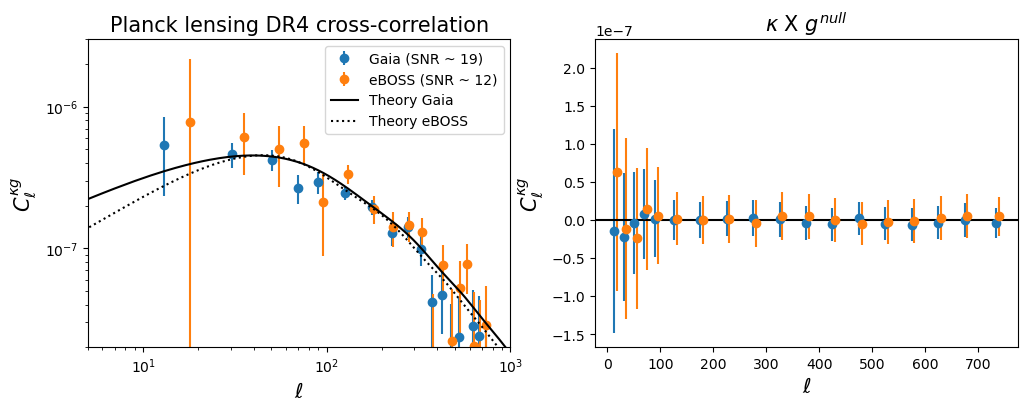

SNR eboss 12.189720820672354
SNR Gaia 18.771124963323143


In [825]:
pl.figure(figsize=(12,4))
pl.subplot(122)
#pl.plot(zgrid,dndz_zerr/dndz_zerr.max())
#pl.plot(dndz_eboss[0],dndz_eboss[1]/dndz_eboss[1].max())

pl.errorbar(lb,gaia_data[70]['G20']['clkgjk'][0],
            gaia_data[70]['G20']['clkgjk'][1],marker='o',ls='',label='Gaia')
pl.errorbar(lb+5,eboss_data[70]['eboss']['clkgjk'][0],
            eboss_data[70]['eboss']['clkgjk'][1],marker='o',ls='',label='eBOSS')
pl.axhline(0,color='black')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell^{\kappa g}$',size=15)
pl.title('$\kappa$ X $g^{null}$',size=15)


pl.subplot(121)
pl.errorbar(lb,gaia_data[70]['G20']['clkg'][0],
            gaia_data[70]['G20']['clkg'][1],marker='o',ls='',label='Gaia (SNR ~ 19)')
pl.errorbar(lb+5,eboss_data[70]['eboss']['clkg'][0],
            eboss_data[70]['eboss']['clkg'][1],marker='o',ls='',label='eBOSS (SNR ~ 12)')
pl.errorbar(ell,cls['W1xP']*p2k,color='black',ls='-',label='Theory Gaia')
pl.errorbar(ell,cls_eboss['W1xP']*p2k,color='black',ls=':',label='Theory eBOSS')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell^{\kappa g}$',size=15)
pl.xscale('log')
pl.yscale('log')
pl.title("Planck lensing DR4 cross-correlation",size=15)
pl.ylim(1e-7/5,3e-6)
pl.xlim(5,1000)
pl.legend()
pl.savefig('/Users/gfabbian/Desktop/gaia_vs_eboss_kg.pdf',bbox_inches='tight')
pl.show()

print('SNR eboss', np.sqrt(np.cumsum(eboss_data[70]['eboss']['clkg'][0]**2/eboss_data[60]['eboss']['clkg'][1]**2)[-1]))
print('SNR Gaia',np.sqrt(np.cumsum(gaia_data[70]['G20']['clkg'][0]**2/gaia_data[70]['G20']['clkg'][1]**2)[-1]))

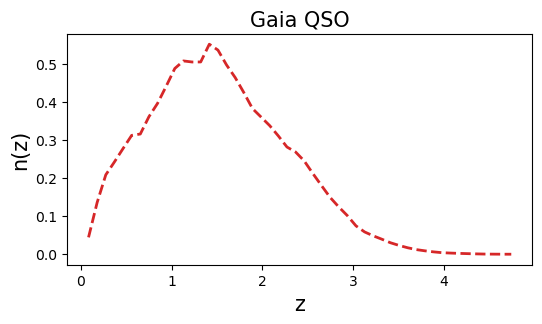

In [817]:
# plot the KDE
pl.figure(figsize=(6,3))
pl.plot(x, rkde.pdf(x)/np.trapz(rkde.pdf(x),dx=np.diff(x)[0]), '--', c='C3', lw=2, label='resampled KDE')
pl.xlabel('z',size=15)
pl.ylabel('n(z)',size=15)
pl.title("Gaia QSO",size=15)
pl.savefig('/Users/gfabbian/Desktop/gaia_qso_dndz.pdf',bbox_inches='tight')
pl.show()

# New catalog tests

In [82]:

mygalmask = sel>0.5
c,c1,c2,cjk   = process_catalog_and_splits(l,b,sel,mygalmask.astype(bool)&mclouds_mask.astype(bool))
c_204,c1_204,c2_204,cjk_204 = process_catalog_and_splits(l204,b204,sel204,mygalmask.astype(bool)&mclouds_mask.astype(bool))

c20,c1_20,c2_20,cjk_20   = process_catalog_and_splits(l20,b20,sel20,mygalmask.astype(bool)&mclouds_mask.astype(bool))
c_205,c1_205,c2_205,cjk_205 = process_catalog_and_splits(l205,b205,sel205,mygalmask.astype(bool)&mclouds_mask.astype(bool))

binning = get_custom_binning(20)

mygalmask = sel>0.5
apomask = nmt.mask_apodization(mygalmask*lensmask_lr,1., apotype="C2")
#apomask = apomask*sel


mygalmask20 = sel20>0.5
apomask20 = nmt.mask_apodization(mygalmask20*lensmask_lr,1., apotype="C2")
#apomask20 = apomask*sel
    
cls_old= process_mask(klrMV,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
cls_20= process_mask(klrMV,c20,c1_20,c2_20,cjk_20,apomask20,binning,w=None,return_error=True)

cls_old_w= process_mask(klrMV,c,c1,c2,cjk,apomask*sel,binning,w=None,return_error=True)
cls_20_w= process_mask(klrMV,c20,c1_20,c2_20,cjk_20,apomask20*sel20,binning,w=None,return_error=True)


mygalmask205 = sel205>0.5
apomask205 = nmt.mask_apodization(mygalmask205*lensmask_lr,1., apotype="C2")
#apomask20 = apomask*sel
    
cls_205_w= process_mask(klrMV,c_205,c1_205,c2_205,cjk_205,apomask205*sel205,binning,w=None,return_error=True)
    


nbar 1.2764245737686408
nbar 2.001610805517411
nbar 1.445606922795337
nbar 2.532698012569387


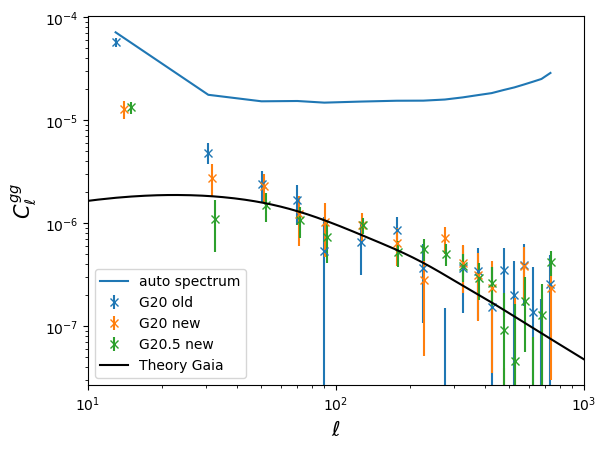

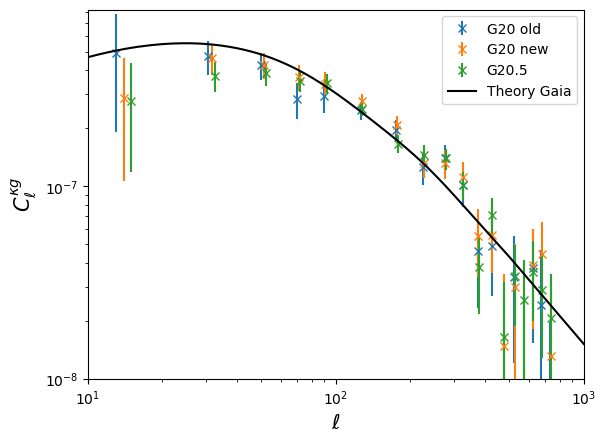

In [110]:
lb = binning.get_effective_ells() 
ell=np.arange(len(cls['W1xW1']))
p2k=ell*(ell+1)/2
pl.errorbar(lb,cls_old_w[0][1],color='C0',label='auto spectrum')
#pl.errorbar(lb,cls_old_w[0][-1],color='C0',ls='--')
#pl.errorbar(lb,cls_old[0][7],cls_old[1][7],color='C0',ls='-',marker='o')
pl.errorbar(lb,cls_old_w[0][7],cls_old_w[1][7],color='C0',ls='',marker='x',label='G20 old')
#pl.errorbar(lb,cls_20[0][1],color='C1')
#pl.errorbar(lb,cls_20[0][7],cls_old[1][7],color='C1',ls='',marker='o')
pl.errorbar(lb+1,cls_20_w[0][7],cls_20_w[1][7],color='C1',ls='',marker='x',label='G20 new')
#pl.errorbar(lb+1,cls_20_w[0][-1],cls_20_w[1][-1],color='C1',ls='-',marker='')
pl.errorbar(lb+2,cls_205_w[0][7],cls_205_w[1][7],color='C2',ls='',marker='x',label='G20.5 new')
pl.errorbar(ell,cls['W1xW1']*2.2**2/b_quasar**2,color='black',ls='-',label='Theory Gaia')
pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.ylabel('$C^{gg}_\ell$',size=15)
pl.xlabel('$\ell$',size=15)
pl.xlim(10,1000)
pl.show()


lb = binning.get_effective_ells() 
#pl.errorbar(lb,cls_old[0][0],cls_old[1][0],color='C0',ls='',marker='o')
pl.errorbar(lb,cls_old_w[0][0],cls_old_w[1][0],color='C0',ls='',marker='x',label='G20 old')
#pl.errorbar(lb+1,cls_20[0][0],cls_20[1][0],color='C1',ls='',marker='o')
pl.errorbar(lb+1,cls_20_w[0][0],cls_20_w[1][0],color='C1',ls='',marker='x',label='G20 new')
pl.errorbar(lb+2,cls_205_w[0][0],cls_205_w[1][0],color='C2',ls='',marker='x',label='G20.5')
pl.errorbar(ell,cls['W1xP']*p2k,color='black',ls='-',label='Theory Gaia')
pl.ylim(1e-08,None)
pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.ylabel('$C^{\kappa g}_\ell$',size=15)
pl.xlabel('$\ell$',size=15)
pl.xlim(10,1000)
pl.show()


In [337]:
print('SNR G20.5w/G20w/G20/G20 old')#cls_205_w[1][0]/cls_old[1][0],cls_20[0][0]/cls_old[0][0]
np.sqrt(np.cumsum(cls_205_w[0][0]**2/cls_205_w[1][0]**2))[-1],\
np.sqrt(np.cumsum(cls_20_w[0][0]**2/cls_20_w[1][0]**2))[-1],\
np.sqrt(np.cumsum(cls_20[0][0]**2/cls_20[1][0]**2))[-1],\
np.sqrt(np.cumsum(cls_old[0][0]**2/cls_old[1][0]**2))[-1]

SNR G20.5w/G20w/G20/G20 old


(26.25185573258478, 21.87950474111577, 21.30002023020138, 18.45564323834809)

fskys 0.5/0.6/0.7/0.8/09 0.681825 0.62698364 0.56934613 0.4826622 0.3587532


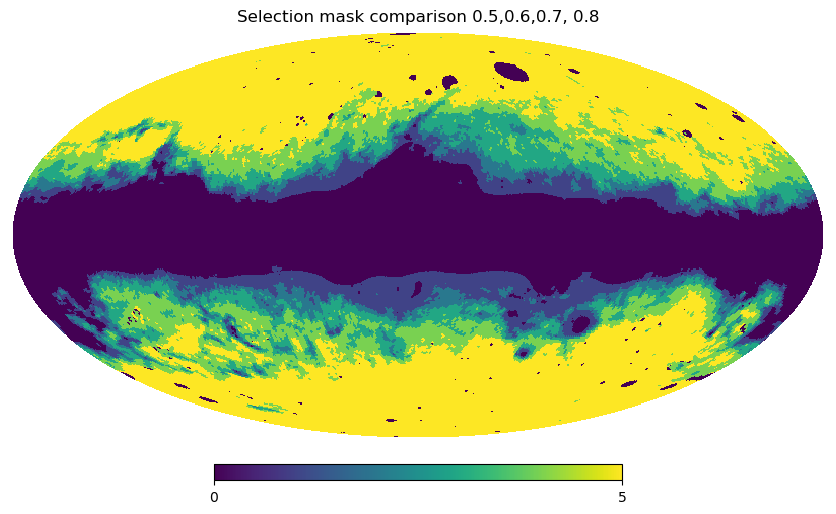

In [346]:
masks05=(sel>0.5).astype(np.float32)
masks04=(sel>0.4).astype(np.float32)
masks03=(sel>0.3).astype(np.float32)
masks06=(sel>0.6).astype(np.float32)
masks07=(sel>0.7).astype(np.float32)
masks08=(sel>0.8).astype(np.float32)
masks09=(sel>0.9).astype(np.float32)
totselmask =lensmask_lr+masks05+masks06+masks07 
totselmask[(lensmask_lr<1)&(mclouds_mask<1)]=0.
totselmask[masks05>0]=1
totselmask[masks06>0]=2
totselmask[masks07>0]=3
totselmask[masks08>0]=4
totselmask[masks09>0]=5*lensmask_lr[masks09>0]#*galmask40_lr[masks09>0]
hp.mollview(totselmask,title='Selection mask comparison 0.5,0.6,0.7, 0.8')
print("fskys 0.5/0.6/0.7/0.8/09",np.mean(masks05),np.mean(masks06),np.mean(masks07),np.mean(masks08),np.mean(masks09))

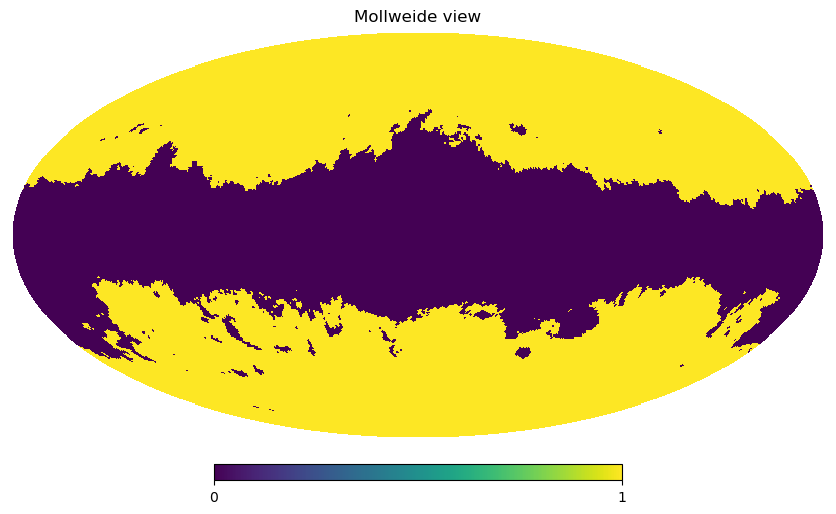

In [373]:
hp.mollview(masks07)

In [510]:
data_test_new={}
for fsky, mygalmask in zip([70,60,50,40,20,0.5],
            [galmask70_lr,galmask60_lr,galmask50_lr,galmask40_lr,galmask20_lr,masks05,masks06,masks07,masks08,masks09]):
    c,c1,c2,cjk   = process_catalog_and_splits(l20,b20,sel20,mygalmask.astype(bool)&mclouds_mask.astype(bool))
    c_205,c1_205,c2_205,cjk_205 = process_catalog_and_splits(l205,b205,sel205,mygalmask.astype(bool)&mclouds_mask.astype(bool))

    
    binning = get_custom_binning(20)
    #apomask = nmt.mask_apodization(galmask70_lr*mclouds_mask,1., apotype="C2")
    apomask = nmt.mask_apodization(mygalmask*lensmask_lr,1., apotype="C2")
    apomask = apomask*sel20
    apomask205 = apomask*sel20
    
    cls_mv= process_mask(klrMV,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_tt= process_mask(klrTT,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pp= process_mask(klrPP,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pr4= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    cls_pr3nosz= process_mask(klrPR3_nosz,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    #cls_pr4_pw= process_mask(klr_pw,c,c1,c2,cjk,apomask,binning,w=None,return_error=True)
    #cls_pr4_all= process_mask(klr,c_all,c1_all,c2_all,cjk_all,apomask,binning,w=None,return_error=True)
    cls_pr4_205= process_mask(klr,c_205,c1_205,c2_205,cjk_205,apomask205,binning,w=None,return_error=True)
    
    
    # gal fg
    cls_pr4fg= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
                templates=None,templates_kappa=[[templates_dict['CIB-GNILC-F353']['data']]])
    cls_pr4fg2= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,templates=[[templates_dict['IRIS']['data']]])
    
    cls_pr4fg_205= process_mask(klr,c_205,c1_205,c2_205,cjk_205,apomask205,binning,w=None,return_error=True,templates=[[templates_dict['CIB-GNILC-F545']['data']]])
    cls_pr4fg2_205= process_mask(klr,c_205,c1_205,c2_205,cjk_205,apomask205,binning,w=None,return_error=True,templates=[[templates_dict['IRIS']['data']]])
    
    # instrumental syst 
    #cls_pr4fg3= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[templates_dict['545-Zodi']['data']]])
    #cls_pr4fg3= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[hp.ud_grade(m10,nside_out=nside)]],templates_kappa = [[hp.ud_grade(m10,nside_out=nside)]])
    
    #cls_pr4fg4= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[hp.ud_grade(stars,nside_out=nside)]],templates_kappa = [[hp.ud_grade(stars,nside_out=nside)]])
    
    #cls_pr4fg3= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[sel]])
    #cls_pr4fg3_mean= process_mask(klr,c,c1,c2,cjk,apomask,binning,w=None,return_error=True,
    #            templates=[[zerrmap_mean]])
    
    [clg1g1,clg1g2,clg2g2,clkgjk,clgjk],[dclg1g1,dclg1g2,dclg2g2,dclkgjk,dclgjk]=process_mask_gXg(klr,l20,b20,apomask,binning,sel20,(mygalmask.astype(bool)&mclouds_mask.astype(bool)),nreal=50,return_error=True)
    [clg1g1_205,clg1g2_205,clg2g2_205,clkgjk_205,clgjk_205],[dclg1g1_205,dclg1g2_205,dclg2g2_205,dclkgjk_205,dclgjk_205]=process_mask_gXg(klr,l205,b205,apomask205,binning,sel205,(mygalmask.astype(bool)&mclouds_mask.astype(bool)),nreal=50,return_error=True)
    
        
    data_test_new[fsky]={'G20':{},'G20.5':{}}
    data_test_new[fsky]['G20']['clkg'] = [cls_pr4[0][0],cls_pr4[1][0]]
    data_test_new[fsky]['G20']['clgXg'] = [clg1g2,dclg1g2]
    data_test_new[fsky]['G20']['clgg'] = [cls_pr4[0][1]-clgjk,cls_pr4[1][1]]
    data_test_new[fsky]['G20']['clgjk'] =  [clgjk,dclgjk]
    data_test_new[fsky]['G20']['clkgjk'] =  [clkgjk,dclkgjk]
    data_test_new[fsky]['G20']['clkk'] =  [cls_pr4[0][2],cls_pr4[1][2]]
    data_test_new[fsky]['G20']['cls_ktt'] =  [cls_tt]
    data_test_new[fsky]['G20']['cls_kpol'] =  [cls_pp]
    data_test_new[fsky]['G20']['cls_kmv'] =  [cls_mv]
    data_test_new[fsky]['G20']['cls_nodust'] =  [cls_pr4fg2]
    data_test_new[fsky]['G20']['cls_nocib'] =  [cls_pr4fg]
    data_test_new[fsky]['G20']['cls_pr3nosz'] =  [cls_pr3nosz]
    
    
    
    data_test_new[fsky]['G20.5']['clkg'] = [cls_pr4_205[0][0],cls_pr4_205[1][0]]
    data_test_new[fsky]['G20.5']['clgXg'] = [clg1g2_205,dclg1g2_205]
    data_test_new[fsky]['G20.5']['clgg'] = [cls_pr4_205[0][1]-clgjk_205,cls_pr4_205[1][1]]
    data_test_new[fsky]['G20.5']['clgjk'] =  [clgjk_205,dclgjk_205]
    data_test_new[fsky]['G20.5']['clkgjk'] =  [clkgjk_205,dclkgjk_205]
    data_test_new[fsky]['G20.5']['clkk'] =  [cls_pr4_205[0][2],cls_pr4_205[1][2]]
    
    
    
    
    # redo for G20.5
    [tot,kgkg,kggg,gggg,kkkk,tot2] = get_covariance_from_model(klr,c,data_model,apomask,binning)
    
    
    
    
    corr_test={}
    corr_test['tot'] = tot2
    #corr_test['tot2'] = tot # wrong normalization of off-diagonal blocks
    corr_test['kgkg'] = kgkg
    corr_test['kggg'] = kggg
    corr_test['kkkk'] = kkkk
    corr_test['gggg'] = gggg
    
    data_test_new[fsky]['corrmat'] = corr_test
    
    #with open("corr_mask.pkl","wb") as f:
    #    pkl.dump(corr_test,f)
        
    
    with open("dataset_kyoto_20230406.pkl","wb") as f:
        pkl.dump(data_test_new,f)

nbar 1.4470629270690076
nbar 2.5389755304260673
Covariance
nbar 1.449802864915109
nbar 2.540872365700634
Covariance
nbar 1.4540790027506008
nbar 2.5453558087453607
Covariance
nbar 1.4593946135198164
nbar 2.548897707796353
Covariance
nbar 1.473001005175427
nbar 2.558755166517252
Covariance
nbar 1.445606922795337
nbar 2.532698012569387
Covariance


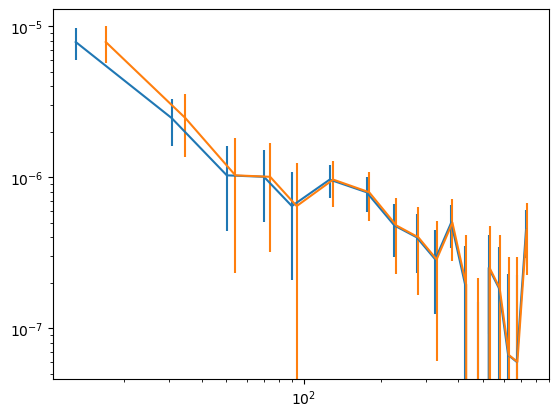

In [508]:
pl.errorbar(lb,data_test_new[50]['G20']['clgg'][0],data_test_new[50]['G20']['clgg'][1])
pl.errorbar(lb+4,data_test_new[50]['G20']['clgXg'][0],data_test_new[50]['G20']['clgXg'][1])
pl.xscale('log')
pl.yscale('log')

# Magnification bias

numbers seems to be roughly consistent between catalogs

Glim 20
20 0.5284307148231819
a-1 m* 20 0.32109152376519284
s m*= 20 0.5284366095060772


/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:39: RuntimeWarning: divide by zero encountered in log10
  s= np.gradient(np.log10(np.cumsum(N)),mstep)
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:40: RuntimeWarning: divide by zero encountered in log10
  s_all= np.gradient(np.log10(np.cumsum(N_all)),mstep)
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:41: RuntimeWarning: divide by zero encountered in log10
  s_highz= np.gradient(np.log10(np.cumsum(N_highz)),mstep)


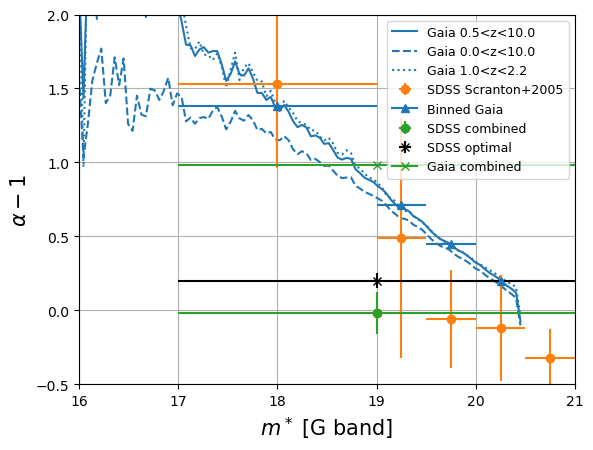

0.35512525446835297
Glim 20.4
0.17963532521231787
0.2388191004096503


/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:89: RuntimeWarning: divide by zero encountered in log10
  print(np.interp(20,xm,np.gradient(np.log10(N),mstep)))
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:92: RuntimeWarning: divide by zero encountered in log10
  print(np.interp(20.4,xm,np.gradient(np.log10(np.cumsum(N)),mstep))/2.5)
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:93: RuntimeWarning: divide by zero encountered in log10
  print(np.interp(20.4,xm,np.gradient(np.log10(N),mstep)))
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:95: RuntimeWarning: divide by zero encountered in log10
  pl.plot(xm,np.log10(np.cumsum(N)),label='log10 (Ncumsum)')
/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1550844884.py:96: RuntimeWarning: divide by zero encountered in log10
  pl.plot(xm,np.log10(N),label='log10(N) +0.9')


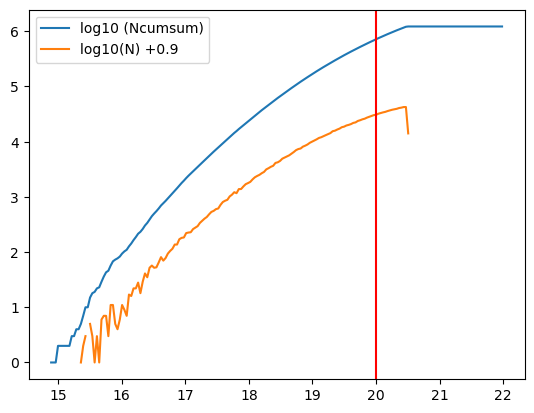

In [502]:
cat=fits.open('../../catalog_spz/gaia_spz_G20.4.fits')
cat2 = fits.open('../../catalog_20230406/catalog_G20.5.fits')
#cat2 = fits.open('../../catalog_20230406/catalog_G20.fits')

zmin_magbias = 0.5
zmax_magbias = 10
nbins=500

#dNdm=np.histogram(cat[1].data['phot_g_mean_mag_1'][(cat[1].data['redshift_spz']>zmin_magbias) & 
#                                                   (cat[1].data['redshift_spz']<zmax_magbias)],bins=nbins,range=(4,22))
#ntot = len(cat[1].data['phot_g_mean_mag_1'])


dNdm=np.histogram(cat2[1].data['phot_g_mean_mag'][(cat2[1].data['redshift_spz']>zmin_magbias) & 
                                                   (cat2[1].data['redshift_spz']<zmax_magbias)],bins=nbins,range=(4,22))
dNdm_all=np.histogram(cat2[1].data['phot_g_mean_mag'][(cat2[1].data['redshift_spz']>0) & 
                                                   (cat2[1].data['redshift_spz']<10)],bins=nbins,range=(4,22))

dNdm_highz=np.histogram(cat2[1].data['phot_g_mean_mag'][(cat2[1].data['redshift_spz']>1) & 
                                                   (cat2[1].data['redshift_spz']<2.2)],bins=nbins,range=(4,22))


ntot = len(cat2[1].data['phot_g_mean_mag'])


mstep = np.diff(dNdm[1])[0]
N=dNdm[0]
N_all=dNdm_all[0]
N_highz=dNdm_highz[0]

xm = dNdm[1][:-1]+mstep/2
#print(stats.linregress(xm[N>100],np.log10(N[N>100])))
#print(stats.linregress(xm[N>100],np.log10(np.cumsum(N))[N>100]))

magbias_sdss_data = [[17 ,19,1.53,0.57],[19  ,19.5,0.49,0.81],[19.5,20,-0.06, 0.33],[20  ,20.5,-0.12,0.36],[20.5,21,-0.32,0.19 ],\
    [17  ,21,-0.02, 0.14]]

print('Glim 20')
s= np.gradient(np.log10(np.cumsum(N)),mstep)
s_all= np.gradient(np.log10(np.cumsum(N_all)),mstep)
s_highz= np.gradient(np.log10(np.cumsum(N_highz)),mstep)
marray = np.linspace(16,20.45,100)
 
print(20,np.interp(20,xm,s)) 
sarray =[]
sarray_all =[]
sarray_highz =[]
for mcut in marray:#[17,18,19,19.5,20,20.2,20.4]:
    s_mstar= np.interp(mcut,xm,s)
    #print(mcut,s_mstar,s_mstar*2.5 -1)
    sarray.append(s_mstar)
    sarray_all.append(np.interp(mcut,xm,s_all))
    sarray_highz.append(np.interp(mcut,xm,s_highz))
                        
alpha_minus_one = 2.5*np.array(sarray) -1
alpha_minus_one_all = 2.5*np.array(sarray_all) -1
alpha_minus_one_highz = 2.5*np.array(sarray_highz) -1

print('a-1','m*',20,np.interp(20,marray,alpha_minus_one))
print('s','m*=',20,np.interp(20,marray,sarray))

pl.plot(marray,alpha_minus_one,label='Gaia %.1f<z<%.1f'%(zmin_magbias,zmax_magbias))
pl.plot(marray,alpha_minus_one_all,label='Gaia %.1f<z<%.1f'%(0,zmax_magbias),color='C0',ls='--')
pl.plot(marray,alpha_minus_one_highz,label='Gaia %.1f<z<%.1f'%(1,2.2),color='C0',ls=':')
for i,magbias_sdss in enumerate(magbias_sdss_data):
    xsdss = (magbias_sdss[0]+magbias_sdss[1])/2
    xerr  = (-magbias_sdss[0]+magbias_sdss[1])/2
    if i==0:
        label_sdss = 'SDSS Scranton+2005'
        label_gaia = 'Binned Gaia'
    else:
        label_sdss = ''
        label_gaia = ''        
    pl.errorbar(xsdss,magbias_sdss[2],yerr=magbias_sdss[3],xerr=xerr,marker='o',ls='',color='C1',label=label_sdss)
    alpha_minus_one_mask = (marray>=magbias_sdss[0]) &(marray<magbias_sdss[1])
    if i!= len(magbias_sdss_data) -1:
        pl.errorbar(xsdss,np.mean(alpha_minus_one[alpha_minus_one_mask]),xerr=xerr,marker='^',color='C0',label=label_gaia)

pl.errorbar(xsdss,magbias_sdss[2],yerr=magbias_sdss[3],xerr=xerr,marker='o',ls='',color='C2',label='SDSS combined')
pl.errorbar(xsdss,0.2,yerr=0.05,xerr=xerr,marker='x',ls='',color='black',label='SDSS optimal')
pl.errorbar(xsdss,np.mean(alpha_minus_one[alpha_minus_one_mask]),xerr=xerr,marker='x',color='C2',label='Gaia combined')
pl.legend(fontsize=9)
pl.grid()
pl.xlabel('$m^*$ [G band]',size=15)
pl.ylabel('$\\alpha -1$',size=15)
pl.xlim(16,21)
pl.ylim(-0.5,2.)
pl.show()
print(np.interp(20,xm,np.gradient(np.log10(N),mstep)))

print('Glim 20.4')
print(np.interp(20.4,xm,np.gradient(np.log10(np.cumsum(N)),mstep))/2.5)
print(np.interp(20.4,xm,np.gradient(np.log10(N),mstep)))

pl.plot(xm,np.log10(np.cumsum(N)),label='log10 (Ncumsum)')
pl.plot(xm,np.log10(N),label='log10(N) +0.9')
pl.legend()
pl.axvline(20,color='red')

In [500]:
cat = fits.open('../../catalog_20230406/catalog_G20.5.fits')

zmin_magbias = 0.
zmax_magbias = 10
nbins = 500
dNdm=np.histogram(cat[1].data['phot_g_mean_mag'][(cat[1].data['redshift_spz']>zmin_magbias) & 
                                                 (cat[1].data['redshift_spz']<zmax_magbias)],bins=nbins,range=(4,22))
ntot = len(cat[1].data['phot_g_mean_mag'])
N=dNdm[0]
mstep = np.diff(dNdm[1])[0]
xm = dNdm[1][:-1]+mstep/2
s = np.gradient(np.log10(np.cumsum(N)),mstep)
print(np.interp(20,xm,s)*2.5-1)

0.2804699387037304


/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_70969/1496761377.py:12: RuntimeWarning: divide by zero encountered in log10
  s = np.gradient(np.log10(np.cumsum(N)),mstep)


# Systematics templates

In [163]:
cat=fits.open('../../catalog_spz/gaia_spz_G20.4.fits')
cat2 = fits.open('../../catalog_20230406/catalog_G20.0.fits')

In [160]:
stars =np.load('../../catalog_spz/map_stars_NSIDE64.npy')
m10 =np.load('../../catalog_spz/map_m10_NSIDE64.npy')
dkate =np.load('../../catalog_spz/map_dust_NSIDE64.npy')

In [280]:

averrmap_old  = make_counts(nside,l,b,cat[1].data['A_v'])
averrmap  = make_counts(nside,l20,b20,cat2[1].data['A_v'])

ebv  = make_counts(nside,l20,b20,cat2[1].data['ebv     '])
ebv_old  = make_counts(nside,l,b,cat[1].data['ebv     '])


zerrmap_old  = make_counts(nside,l,b,zerr)
zerrmap  = make_counts(nside,l20,b20,zerr20)

parerrmap  = make_counts(nside,l20,b20,cat2[1].data['parallax_error'])

photo_g_nobs  = make_counts(nside,l20,b20,cat2[1].data['phot_g_n_obs'])
photo_bp_nobs  = make_counts(nside,l20,b20,cat2[1].data['phot_bp_n_obs'])
photo_rp_nobs  = make_counts(nside,l20,b20,cat2[1].data['phot_rp_n_obs'])



107501.56051268242 638860.0
134266.05922221765 746647.0
43311.63333939132 746647.0
34677.92381355958 638860.0
61765.57360514911 638860.0
101382.81854192047 746647.0
350723.3139767656 746647.0
262705479.0 746647.0
27013279.0 746647.0
26849606.0 746647.0


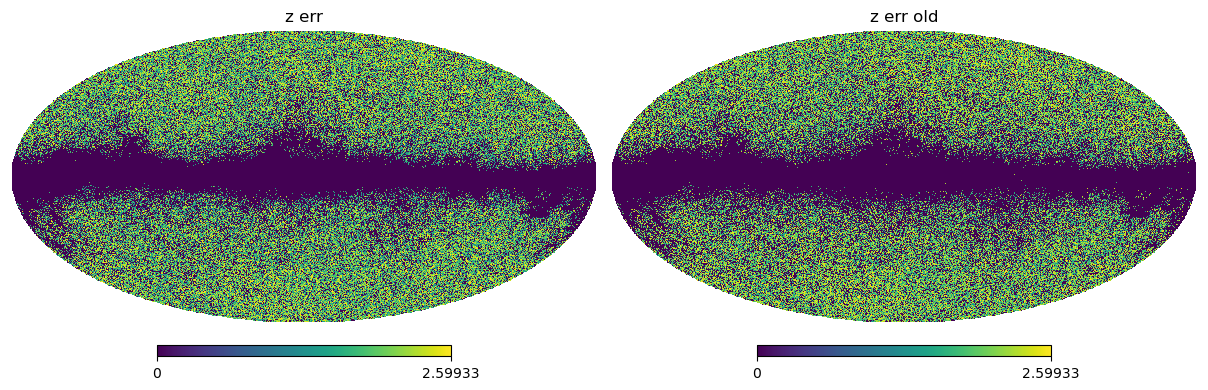

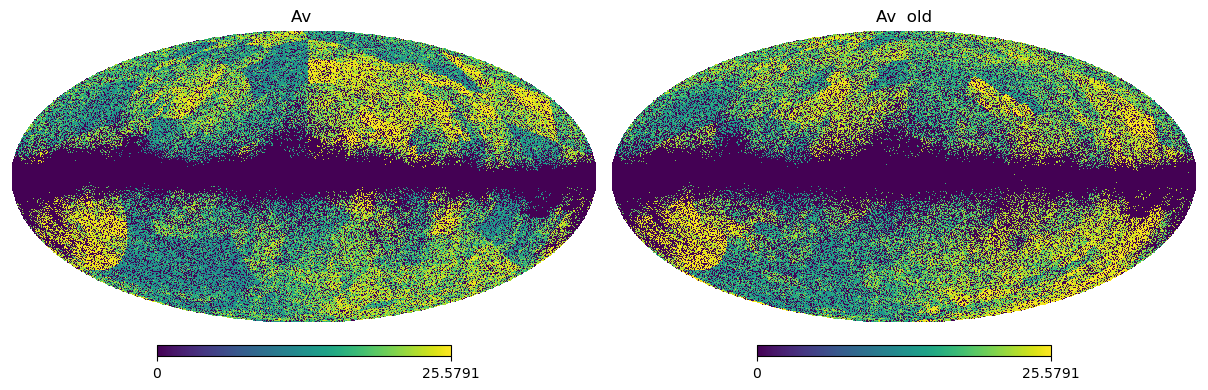

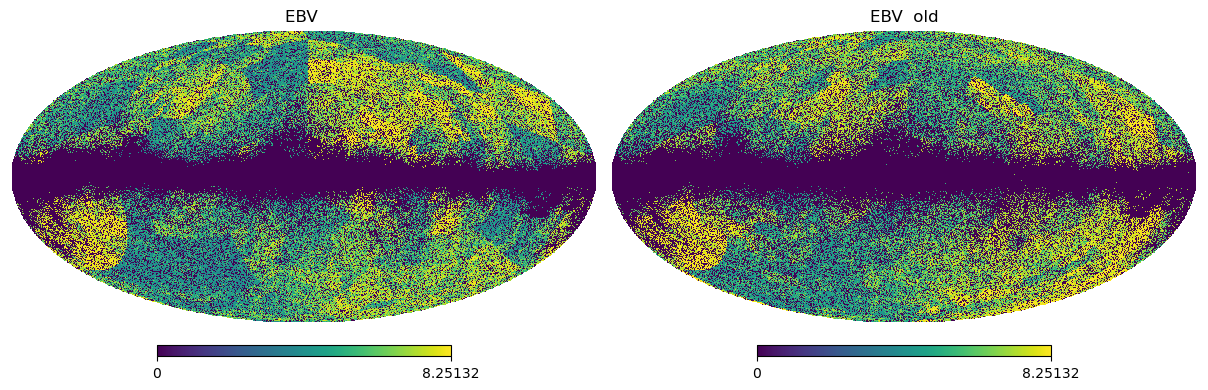

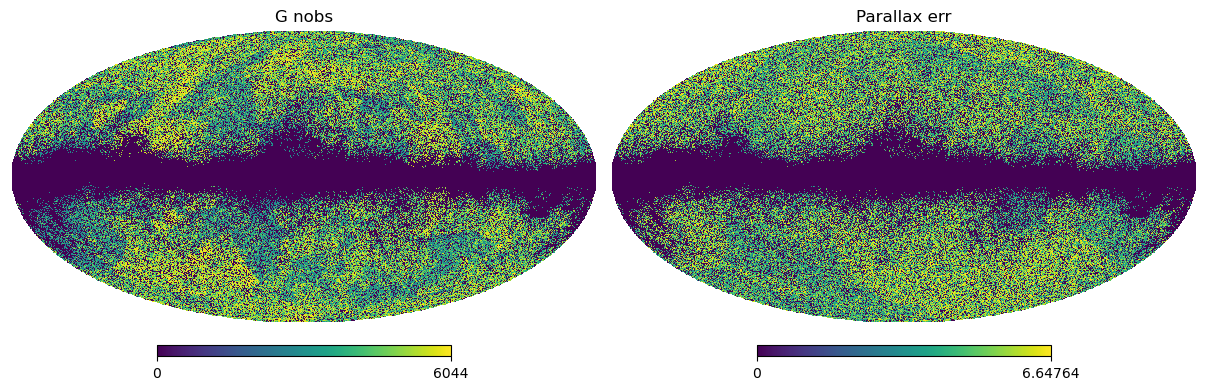

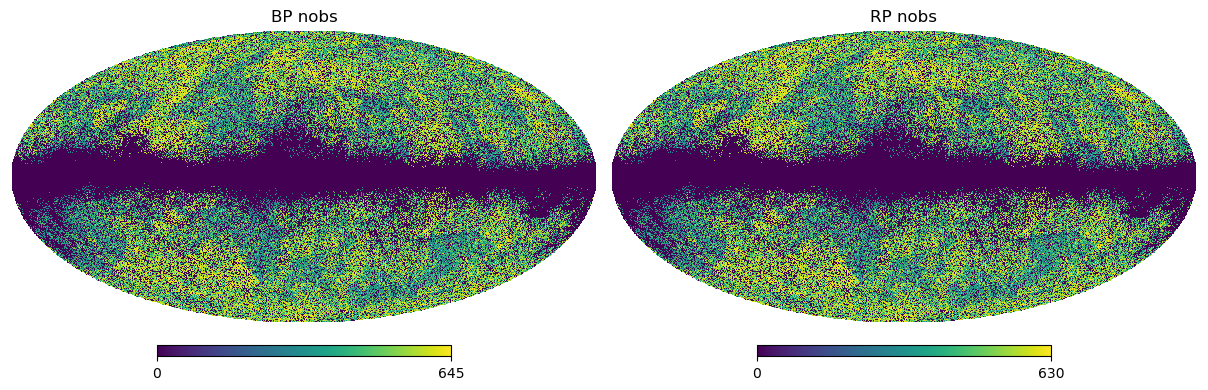

In [282]:
#help(hp.mollview)
pl.figure(figsize=(12,4))
hp.mollview(zerrmap,norm='hist',sub=121,title='z err',max=max([zerrmap.max(),zerrmap_old.max()]))
hp.mollview(zerrmap_old,norm='hist',sub=122,title = 'z err old',max=max([zerrmap.max(),zerrmap_old.max()]))
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(averrmap,norm='hist',sub=121,title='Av ',max=max([averrmap.max(),averrmap_old.max()]))
hp.mollview(averrmap_old,norm='hist',sub=122,title = 'Av  old',max=max([averrmap.max(),averrmap_old.max()]))
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(ebv,norm='hist',sub=121,title='EBV ',max=max([ebv.max(),ebv_old.max()]))
hp.mollview(ebv_old,norm='hist',sub=122,title = 'EBV  old',max=max([ebv.max(),ebv_old.max()]))
pl.show()


pl.figure(figsize=(12,4))
hp.mollview(photo_g_nobs,norm='hist',sub=121,title='G nobs')
hp.mollview(parerrmap,norm='hist',sub=122,title = 'Parallax err')
pl.show() 

pl.figure(figsize=(12,4))
hp.mollview(photo_bp_nobs,norm='hist',sub=121,title='BP nobs')
hp.mollview(photo_rp_nobs,norm='hist',sub=122,title = 'RP nobs')
pl.show() 

#hp.mollview(zerrmap20,norm='hist')
#hp.mollview(stars,norm='hist',coord=['C','G'])
#hp.mollview(m10,norm='hist',coord=['C','G'])
#hp.mollview(dkate,norm='hist',coord=['C','G'])
#pl.show()
#pl.loglog(hp.anafast(m10))
#pl.loglog(hp.anafast(dkate))
#pl.loglog(hp.anafast(stars))
#hp.mollview(ebv,norm='hist')
#hp.mollview(zerrmap_mean/zerrmap.max(),norm='hist')
#hp.mollview(templates_dict['SFD']['data'],norm='hist')
#hp.mollview(hp.ud_grade(hp.ud_grade(zerrmap/zerrmap.max(),nside_out=64),nside_out=256)*galmask70_lr,norm='hist')
#hp.mollview(hp.ud_grade(hp.ud_grade(sel,nside_out=64),nside_out=256)*galmask70_lr,norm='hist')


In [258]:
cl_ss = []
cl_ks = []
cl_gs = []
cl_g1s = []
cl_g2s = []

clkk_s = []
clkg_s = []
clgg_s = []
clg1g1_s = []
clg1g2_s = []
clg2g2_s = []

alpha_kg = []
alpha_gg = []
alpha_g1g2 = []

dalpha_kg = []
dalpha_gg = []
dalpha_g1g2 = []


#for i,(s_temp,bl_t,s_mask) in enumerate(zip(s_list,bls_list,s_mask_list)):
for i,(s_temp,bl_t,s_mask) in enumerate(zip([hp.ud_grade(stars,nside_out=nside),hp.ud_grade(m10,nside_out=nside)],
                                            [hp.pixwin(nside,False,lmax),hp.pixwin(nside,False,lmax)],[apomask,apomask])):
    #alpha_mask = analysis_mask*s_mask
    alpha_mask = s_mask
    delta_b = binning.get_nell_list()
    dof = (2*lb+1)*delta_b*np.mean(alpha_mask**2)**2/np.mean(alpha_mask**4)
    #if type(s_mask) is np.ndarray:
    #    print("Correcting mask",tname[i],np.mean(alpha_mask))

    f0 = nmt.NmtField(alpha_mask, [klr],beam=beam) 
    fc = nmt.NmtField(alpha_mask, [c],beam=beam)
    fc1 = nmt.NmtField(alpha_mask, [c1],beam=beam)
    fc2 = nmt.NmtField(alpha_mask, [c2],beam=beam)
    
    ft = nmt.NmtField(alpha_mask, [s_temp],beam=beam)

    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f0, f0, binning)      
    

    clkk_s.append(compute_master(f0,f0,w)[0])
    clkg_s.append(compute_master(f0,fc,w)[0])    
    clgg_s.append(compute_master(fc,fc,w)[0])
    clg1g2_s.append(compute_master(fc1,fc2,w)[0])
    clg1g1_s.append(compute_master(fc1,fc1,w)[0])
    clg1g2_s.append(compute_master(fc1,fc2,w)[0])    
    clg2g2_s.append(compute_master(fc2,fc2,w)[0])    
    
    cl_ss.append(compute_master(ft,ft,w)[0])
    cl_ks.append(compute_master(f0,ft,w)[0])    
    cl_gs.append(compute_master(fc,ft,w)[0])        
    
    cl_g1s.append(compute_master(fc1,ft,w)[0])        
    cl_g2s.append(compute_master(fc1,ft,w)[0])        
    
    dss = np.sqrt(2*cl_ss[-1]**2/dof)
    dgs =np.sqrt(clgg_s[-1]*cl_ss[-1] +cl_gs[-1]**2)/np.sqrt(dof)
    dg1s =np.sqrt(clg1g1_s[-1]*cl_ss[-1] +cl_g1s[-1]**2)/np.sqrt(dof)
    dg2s =np.sqrt(clg2g2_s[-1]*cl_ss[-1] +cl_g2s[-1]**2)/np.sqrt(dof)    
    dks =np.sqrt(clkk_s[-1]*cl_ss[-1] +cl_ks[-1]**2)/np.sqrt(dof)    

    alpha_kg.append(cl_gs[-1]*cl_ks[-1]/cl_ss[-1])
    alpha_gg.append(cl_gs[-1]**2/cl_ss[-1])    
    alpha_g1g2.append(cl_g1s[-1]*cl_g2s[-1]/cl_ss[-1])     

    dakg = np.sqrt(alpha_kg[-1]**2*((dgs/cl_gs[-1])**2+ (dks/cl_ks[-1])**2+ (dss/cl_ss[-1])**2))
    dakg[dakg!=dakg]=0.    
    dalpha_kg.append(dakg)

    dagg = np.sqrt(alpha_gg[-1]**2*(4*(dgs/cl_gs[-1])**2+ (dss/cl_ss[-1])**2))
    dagg[dagg!=dagg]=0.
    dalpha_gg.append(dagg)
    
    dag1g2 = np.sqrt(alpha_g1g2[-1]**2*((dg1s/cl_g1s[-1])**2+ (dg2s/cl_g2s[-1])**2+ (dss/cl_ss[-1])**2))
    dag1g2[dag1g2!=dag1g2]=0.
    dalpha_g1g2.append(dag1g2)    
    
    # when no template normalization can be obtained set  (i.e. auto spectrun <0) set to 0 the correction
    alpha_kg[-1][cl_ss[-1]<0] = 0.
    alpha_gg[-1][cl_ss[-1]<0] = 0.
    alpha_g1g2[-1][cl_ss[-1]<0] = 0.    

    

# Redshift isotropy

In [209]:
nside_isotest = 4
zisotropy = np.where(hp.ud_grade(galmask50_lr,nside_out=nside_isotest)>=0.9)[0]
p64= hp.ang2pix(nside_isotest,l,b,lonlat=True)
p64_204= hp.ang2pix(nside_isotest, l204,b204,lonlat=True)

npts=600
zgrid=np.linspace(0,6,npts)
dndz_iso={}
dndz_iso204={}

for p64_i in zisotropy:#np.arange(hp.nside2npix(nside_isotest)):
    nqso_iso = np.sum(p64==p64_i)
    nqso_iso204 = np.sum(p64_204==p64_i)    
#    print(p64_i,zisotropy)
    dndz_iso[p64_i]  = np.zeros(npts)
    dndz_iso204[p64_i]  = np.zeros(npts)
    zmask_iso = p64==p64_i
    zmask_iso204 = p64_204==p64_i  
    z_zmask_iso= z[zmask_iso]
    zerr_zmask_iso= zerr204[zmask_iso204]    
    z_zmask_iso204= z204[zmask_iso204]
    zerr_zmask_iso204= zerr204[zmask_iso204]        
    for i in range(nqso_iso):
        dndz_iso[p64_i]+= np.exp(-(z_zmask_iso[i]-zgrid)**2/(0.5*zerr_zmask_iso[i]**2))/np.sqrt(2*np.pi)/zerr_zmask_iso[i]
    for i in range(nqso_iso204):
        dndz_iso204[p64_i]+= np.exp(-(z_zmask_iso204[i]-zgrid)**2/(0.5*zerr_zmask_iso204[i]**2))/np.sqrt(2*np.pi)/zerr_zmask_iso204[i]
        
    

    dndz_iso[p64_i]=nqso_iso*dndz_iso[p64_i]/np.trapz(dndz_iso[p64_i],dx=np.diff(zgrid)[0])
    dndz_iso204[p64_i]=nqso_iso204*dndz_iso204[p64_i]/np.trapz(dndz_iso204[p64_i],dx=np.diff(zgrid)[0])


KeyboardInterrupt: 

In [ ]:
def bz_sdss_photo(z):
    return 1+((1+np.array(z))/2.5)**5
cls_auto_iso=[]
cls_cross_iso=[]
#print(np.sum(dndz_iso[p64_i])*np.diff(zgrid)[0],nqso_iso)
for k in dndz_iso.keys():
#    norm = np.trapz(dndz_iso[k],dx=np.diff(zgrid)[0])
#    #pl.errorbar(zgrid,dndz_iso[k],np.sqrt(dndz_iso[k])/np.sqrt(0.01001669449081803))#/np.trapz(dndz_iso[k],dx=np.diff(zgrid)[0]))
    pl.errorbar(zgrid,dndz_iso[k]/norm,np.sqrt(dndz_iso[k])/np.sqrt(0.01001669449081803)/norm)
#    print(k,np.percentile(dndz_iso[k]/np.trapz(dndz_iso[k],dx=np.diff(zgrid)[0]),[16,50,84]))
#pl.yscale('log')
#pl.ylim(1e-02,1)
#pl.xscale('log')
pl.show()


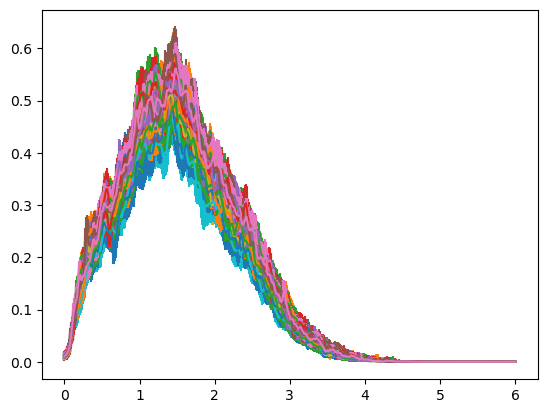

In [587]:
def bz_sdss_photo(z):
    return 1+((1+np.array(z))/2.5)**5

#print(np.sum(dndz_iso[p64_i])*np.diff(zgrid)[0],nqso_iso)
for k in dndz_iso.keys():
#    norm = np.trapz(dndz_iso[k],dx=np.diff(zgrid)[0])
#    #pl.errorbar(zgrid,dndz_iso[k],np.sqrt(dndz_iso[k])/np.sqrt(0.01001669449081803))#/np.trapz(dndz_iso[k],dx=np.diff(zgrid)[0]))
    pl.errorbar(zgrid,dndz_iso[k]/norm,np.sqrt(dndz_iso[k])/np.sqrt(0.01001669449081803)/norm)
#    print(k,np.percentile(dndz_iso[k]/np.trapz(dndz_iso[k],dx=np.diff(zgrid)[0]),[16,50,84]))
#pl.yscale('log')
#pl.ylim(1e-02,1)
#pl.xscale('log')
pl.show()

cls_auto_iso=[]
cls_cross_iso=[]
for k in dndz_iso.keys():
    pars = init_pars()
    W=np.array(dndz_iso[k])
    z_W=np.array(zgrid)
    pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(z_W), z=z_W, W=W,source_type='counts',dlog10Ndm = 0.0)]
    results = camb.get_results(pars)
    cls = results.get_source_cls_dict(raw_cl=True) 
    cls_auto_iso.append(cls['W1xW1'])
    cls_cross_iso.append(cls['W1xP'])    
    
